In [2]:
import sys
import warnings

if not sys.warnoptions:
    warnings.simplefilter('ignore')

from alpha_vantage.timeseries import TimeSeries
import matplotlib.pyplot as plt

ts = TimeSeries(key='8VHYYYZR0BTCNJ2F', output_format='pandas')

In [3]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import datetime
sns.set()
tf.compat.v1.random.set_random_seed(1234)

In [3]:
df,_ = ts.get_daily(symbol='MSFT', outputsize='full')
df.iloc[0:253, 3:4]

,4. close
date,
2020-03-12,139.06
2020-03-11,153.63
2020-03-10,160.92
2020-03-09,150.62
2020-03-06,161.57
2020-03-05,166.27
2020-03-04,170.55
2020-03-03,164.51
2020-03-02,172.79


In [9]:
#df = np.load('msft.npy')
#df = pd.DataFrame(data=df, columns=["4. close"])

In [10]:
minmax = MinMaxScaler().fit(df.iloc[0:253, 3:4].astype('float32')) # Close index
df_log = minmax.transform(df.iloc[0:253, 3:4].astype('float32')) # Close index
df_log = pd.DataFrame(df_log)
df = df.iloc[0:253, 3:4]

In [72]:
data = np.array(df)
np.save('msft.npy', data)

In [11]:
test_size = 30
simulation_size = 10

df_train = df_log.iloc[:-test_size]
df_test = df_log.iloc[-test_size:]
df.shape, df_train.shape, df_test.shape

((253, 1), (223, 1), (30, 1))

In [12]:
# Root Mean Square Error
def calculate_accuracy(real, predict):
    real = np.array(real) + 1
    predict = np.array(predict) + 1
    percentage = 1 - np.sqrt(np.mean(np.square((real - predict) / real)))
    return percentage * 100

def anchor(signal, weight):
    buffer = []
    last = signal[0]
    for i in signal:
        smoothed_val = last * weight + (1 - weight) * i
        buffer.append(smoothed_val)
        last = smoothed_val
    return buffer

In [56]:
num_layers = 1
size_layer = 128
timestamp = 5
epoch = 300
dropout_rate = 0.8
future_day = test_size
learning_rate = 0.005

In [57]:
class LSTM:
    def __init__(
        self,
        learning_rate,
        num_layers,
        size,
        size_layer,
        output_size,
        forget_bias = 0.1,
    ):
        def lstm_cell(size_layer):
            return tf.nn.rnn_cell.LSTMCell(size_layer, state_is_tuple = False)

        rnn_cells = tf.nn.rnn_cell.MultiRNNCell(
            [lstm_cell(size_layer) for _ in range(num_layers)],
            state_is_tuple = False,
        )
        self.X = tf.placeholder(tf.float32, (None, None, size))
        self.Y = tf.placeholder(tf.float32, (None, output_size))
        drop = tf.contrib.rnn.DropoutWrapper(
            rnn_cells, output_keep_prob = forget_bias
        )
        self.hidden_layer = tf.placeholder(
            tf.float32, (None, num_layers * 2 * size_layer)
        )
        self.outputs, self.last_state = tf.nn.dynamic_rnn(
            drop, self.X, initial_state = self.hidden_layer, dtype = tf.float32
        )
        self.logits = tf.layers.dense(self.outputs[-1], output_size)
        self.cost = tf.compat.v1.losses.mean_squared_error(self.Y, self.logits)
        self.optimizer = tf.train.AdamOptimizer(learning_rate).minimize(
            self.cost
        )


In [58]:
results = []
for i in range(simulation_size):
    print('simulation %d'%(i + 1))
    tf.reset_default_graph()
    modelnn = LSTM(
        learning_rate, num_layers, df_log.shape[1], size_layer, df_log.shape[1], dropout_rate
    )
    sess = tf.InteractiveSession()
    sess.run(tf.global_variables_initializer())
    now = datetime.datetime.now()
    
    ## Training
    for i in range(epoch):
        init_value = np.zeros((1, num_layers * 2 * size_layer))
        total_loss, total_acc = [], []
        for k in range(0, df_train.shape[0] - 1, timestamp):
            index = min(k + timestamp, df_train.shape[0] - 1)
            batch_x = np.expand_dims(
                df_train.iloc[k : index, :].values, axis = 0
            )
            batch_y = df_train.iloc[k + 1 : index + 1, :].values
            logits, last_state, _, loss = sess.run(
                [modelnn.logits, modelnn.last_state, modelnn.optimizer, modelnn.cost],
                feed_dict = {
                    modelnn.X: batch_x,
                    modelnn.Y: batch_y,
                    modelnn.hidden_layer: init_value,
                },
            )        
            init_value = last_state
            total_loss.append(loss)
            total_acc.append(calculate_accuracy(batch_y[:, 0], logits[:, 0]))
    
    fin = datetime.datetime.now()
    print(fin-now)
    
    ## Testing
    future_day = test_size

    output_predict = np.zeros((df_train.shape[0] + future_day, df_train.shape[1]))
    output_predict[0] = df_train.iloc[0]
    upper_b = (df_train.shape[0] // timestamp) * timestamp
    init_value = np.zeros((1, num_layers * 2 * size_layer))

    for k in range(0, (df_train.shape[0] // timestamp) * timestamp, timestamp):
        out_logits, last_state = sess.run(
            [modelnn.logits, modelnn.last_state],
            feed_dict = {
                modelnn.X: np.expand_dims(
                    df_train.iloc[k : k + timestamp], axis = 0
                ),
                modelnn.hidden_layer: init_value,
            },
        )
        init_value = last_state
        output_predict[k + 1 : k + timestamp + 1] = out_logits

    if upper_b != df_train.shape[0]:
        out_logits, last_state = sess.run(
            [modelnn.logits, modelnn.last_state],
            feed_dict = {
                modelnn.X: np.expand_dims(df_train.iloc[upper_b:], axis = 0),
                modelnn.hidden_layer: init_value,
            },
        )
        output_predict[upper_b + 1 : df_train.shape[0] + 1] = out_logits
        future_day -= 1

    init_value = last_state
    
    for i in range(future_day):
        o = output_predict[-future_day - timestamp + i:-future_day + i]
        out_logits, last_state = sess.run(
            [modelnn.logits, modelnn.last_state],
            feed_dict = {
                modelnn.X: np.expand_dims(o, axis = 0),
                modelnn.hidden_layer: init_value,
            },
        )
        init_value = last_state
        output_predict[-future_day + i] = out_logits[-1]
    
    output_predict = minmax.inverse_transform(output_predict)
    deep_future = anchor(output_predict[:, 0], 0.3)
    results.append(deep_future[-test_size:])

W0314 22:55:42.591009 140339716040512 rnn_cell_impl.py:893] <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x7f99be602a58>: Using a concatenated state is slower and will soon be deprecated.  Use state_is_tuple=True.


simulation 1
0:03:11.483193


W0314 22:59:21.614080 140339716040512 rnn_cell_impl.py:893] <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x7f99be089cc0>: Using a concatenated state is slower and will soon be deprecated.  Use state_is_tuple=True.


simulation 2
0:03:11.164973


W0314 23:02:33.767399 140339716040512 rnn_cell_impl.py:893] <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x7f99bc5a3160>: Using a concatenated state is slower and will soon be deprecated.  Use state_is_tuple=True.


simulation 3
0:03:06.832998


W0314 23:05:41.543576 140339716040512 rnn_cell_impl.py:893] <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x7f999e6b7400>: Using a concatenated state is slower and will soon be deprecated.  Use state_is_tuple=True.


simulation 4
0:03:11.228787


W0314 23:08:53.707827 140339716040512 rnn_cell_impl.py:893] <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x7f999e1e9fd0>: Using a concatenated state is slower and will soon be deprecated.  Use state_is_tuple=True.


simulation 5
0:03:14.496296


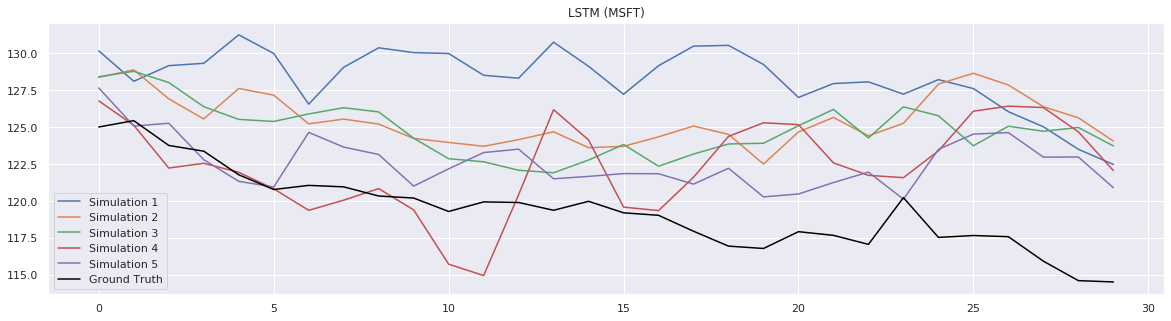

[92.24508612726017,
 94.4005454389727,
 95.0607149703549,
 95.60395718174844,
 96.60928892794448]

In [59]:
acc1 = [calculate_accuracy(df['4. close'].iloc[-test_size:].values, r) for r in results]
top_5_idx = np.argsort(acc1)[-5:]
results = [results[i] for i in top_5_idx]
acc1 = [calculate_accuracy(df['4. close'].iloc[-test_size:].values, r) for r in results]

plt.figure(figsize = (20, 5))
for no, r in enumerate(results):
    plt.plot(r, label = 'Simulation %d'%(no + 1))
    
plt.plot(df['4. close'].iloc[-test_size:].values, label = 'Ground Truth', c = 'black')
plt.legend()
plt.title('LSTM (MSFT)')
plt.show()
acc1

In [60]:
class LSTM_bid:
    def __init__(
        self,
        learning_rate,
        num_layers,
        size,
        size_layer,
        output_size,
        forget_bias = 0.1,
    ):
        def lstm_cell(size_layer):
            return tf.nn.rnn_cell.LSTMCell(size_layer, state_is_tuple = False)

        backward_rnn_cells = tf.nn.rnn_cell.MultiRNNCell(
            [lstm_cell(size_layer) for _ in range(num_layers)],
            state_is_tuple = False,
        )
        forward_rnn_cells = tf.nn.rnn_cell.MultiRNNCell(
            [lstm_cell(size_layer) for _ in range(num_layers)],
            state_is_tuple = False,
        )
        self.X = tf.placeholder(tf.float32, (None, None, size))
        self.Y = tf.placeholder(tf.float32, (None, output_size))
        drop_backward = tf.contrib.rnn.DropoutWrapper(
            backward_rnn_cells, output_keep_prob = forget_bias
        )
        forward_backward = tf.contrib.rnn.DropoutWrapper(
            forward_rnn_cells, output_keep_prob = forget_bias
        )
        self.backward_hidden_layer = tf.placeholder(
            tf.float32, shape = (None, num_layers * 2 * size_layer)
        )
        self.forward_hidden_layer = tf.placeholder(
            tf.float32, shape = (None, num_layers * 2 * size_layer)
        )
        self.outputs, self.last_state = tf.nn.bidirectional_dynamic_rnn(
            forward_backward,
            drop_backward,
            self.X,
            initial_state_fw = self.forward_hidden_layer,
            initial_state_bw = self.backward_hidden_layer,
            dtype = tf.float32,
        )
        self.outputs = tf.concat(self.outputs, 2)
        self.logits = tf.layers.dense(self.outputs[-1], output_size)
        self.cost = tf.compat.v1.losses.mean_squared_error(self.Y, self.logits)
        self.optimizer = tf.train.AdamOptimizer(learning_rate).minimize(
            self.cost
        )

In [61]:
results2 = []
for i in range(simulation_size):
    print('simulation %d'%(i + 1))
    tf.reset_default_graph()
    modelnn = LSTM_bid(
        learning_rate, num_layers, df_log.shape[1], size_layer, df_log.shape[1], dropout_rate
    )
    sess = tf.InteractiveSession()
    sess.run(tf.global_variables_initializer())
    now = datetime.datetime.now()
    
    ## Training
    for i in range(epoch):
        init_value_forward = np.zeros((1, num_layers * 2 * size_layer))
        init_value_backward = np.zeros((1, num_layers * 2 * size_layer))
        total_loss, total_acc = [], []
        for k in range(0, df_train.shape[0] - 1, timestamp):
            index = min(k + timestamp, df_train.shape[0] - 1)
            batch_x = np.expand_dims(
                df_train.iloc[k : index, :].values, axis = 0
            )
            batch_y = df_train.iloc[k + 1 : index + 1, :].values
            logits, last_state, _, loss = sess.run(
                [modelnn.logits, modelnn.last_state, modelnn.optimizer, modelnn.cost],
                feed_dict = {
                    modelnn.X: batch_x,
                    modelnn.Y: batch_y,
                    modelnn.backward_hidden_layer: init_value_backward,
                    modelnn.forward_hidden_layer: init_value_forward,
                },
            )        
            init_value_forward = last_state[0]
            init_value_backward = last_state[1]
            total_loss.append(loss)
            total_acc.append(calculate_accuracy(batch_y[:, 0], logits[:, 0]))
    
    fin = datetime.datetime.now()
    print(fin-now)
    ## Testing
    future_day = test_size

    output_predict = np.zeros((df_train.shape[0] + future_day, df_train.shape[1]))
    output_predict[0] = df_train.iloc[0]
    upper_b = (df_train.shape[0] // timestamp) * timestamp
    init_value_forward = np.zeros((1, num_layers * 2 * size_layer))
    init_value_backward = np.zeros((1, num_layers * 2 * size_layer))

    for k in range(0, (df_train.shape[0] // timestamp) * timestamp, timestamp):
        out_logits, last_state = sess.run(
            [modelnn.logits, modelnn.last_state],
            feed_dict = {
                modelnn.X: np.expand_dims(
                    df_train.iloc[k : k + timestamp], axis = 0
                ),
                modelnn.backward_hidden_layer: init_value_backward,
                modelnn.forward_hidden_layer: init_value_forward,
            },
        )
        init_value_forward = last_state[0]
        init_value_backward = last_state[1]
        output_predict[k + 1 : k + timestamp + 1] = out_logits

    if upper_b != df_train.shape[0]:
        out_logits, last_state = sess.run(
            [modelnn.logits, modelnn.last_state],
            feed_dict = {
                modelnn.X: np.expand_dims(df_train.iloc[upper_b:], axis = 0),
                modelnn.backward_hidden_layer: init_value_backward,
                modelnn.forward_hidden_layer: init_value_forward,
            },
        )
        output_predict[upper_b + 1 : df_train.shape[0] + 1] = out_logits
        future_day -= 1

    init_value_forward = last_state[0]
    init_value_backward = last_state[1]
    
    for i in range(future_day):
        o = output_predict[-future_day - timestamp + i:-future_day + i]
        out_logits, last_state = sess.run(
            [modelnn.logits, modelnn.last_state],
            feed_dict = {
                modelnn.X: np.expand_dims(o, axis = 0),
                modelnn.backward_hidden_layer: init_value_backward,
                modelnn.forward_hidden_layer: init_value_forward,
            },
        )
        init_value_forward = last_state[0]
        init_value_backward = last_state[1]
        output_predict[-future_day + i] = out_logits[-1]
    
    output_predict = minmax.inverse_transform(output_predict)
    deep_future = anchor(output_predict[:, 0], 0.3)
    
    results2.append(deep_future[-test_size:])

W0314 23:36:51.275874 140339716040512 rnn_cell_impl.py:893] <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x7f9984b3ea90>: Using a concatenated state is slower and will soon be deprecated.  Use state_is_tuple=True.
W0314 23:36:51.277929 140339716040512 rnn_cell_impl.py:893] <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x7f9984b3ec88>: Using a concatenated state is slower and will soon be deprecated.  Use state_is_tuple=True.


simulation 1
0:04:58.005399


W0314 23:41:50.840300 140339716040512 rnn_cell_impl.py:893] <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x7f99849a7780>: Using a concatenated state is slower and will soon be deprecated.  Use state_is_tuple=True.
W0314 23:41:50.843975 140339716040512 rnn_cell_impl.py:893] <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x7f9967f98390>: Using a concatenated state is slower and will soon be deprecated.  Use state_is_tuple=True.


simulation 2
0:04:54.440747


W0314 23:46:48.323956 140339716040512 rnn_cell_impl.py:893] <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x7f998642dac8>: Using a concatenated state is slower and will soon be deprecated.  Use state_is_tuple=True.
W0314 23:46:48.328659 140339716040512 rnn_cell_impl.py:893] <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x7f9965db6dd8>: Using a concatenated state is slower and will soon be deprecated.  Use state_is_tuple=True.


simulation 3
0:04:49.441838


W0314 23:51:39.342323 140339716040512 rnn_cell_impl.py:893] <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x7f9965d7ae48>: Using a concatenated state is slower and will soon be deprecated.  Use state_is_tuple=True.
W0314 23:51:39.345904 140339716040512 rnn_cell_impl.py:893] <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x7f994f805c18>: Using a concatenated state is slower and will soon be deprecated.  Use state_is_tuple=True.


simulation 4
0:04:50.987021


W0314 23:56:31.882386 140339716040512 rnn_cell_impl.py:893] <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x7f994f860048>: Using a concatenated state is slower and will soon be deprecated.  Use state_is_tuple=True.
W0314 23:56:31.885928 140339716040512 rnn_cell_impl.py:893] <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x7f994d417198>: Using a concatenated state is slower and will soon be deprecated.  Use state_is_tuple=True.


simulation 5
0:04:50.307562


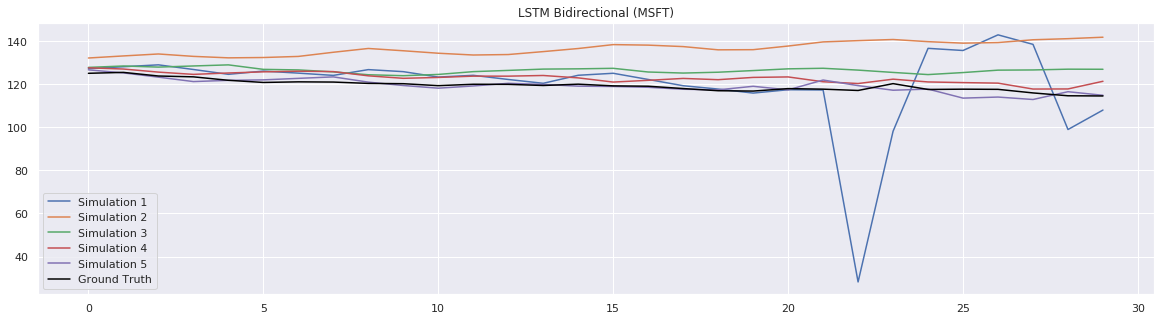

[83.9621854704895,
 84.938368932674,
 93.72417868770047,
 96.81752156626378,
 98.44691143096142]

In [13]:
acc2 = [calculate_accuracy(df['4. close'].iloc[-test_size:].values, r) for r in results2]
top_5_idx = np.argsort(acc2)[-5:]
results2 = [results2[i] for i in top_5_idx]
acc2 = [calculate_accuracy(df['4. close'].iloc[-test_size:].values, r) for r in results2]

plt.figure(figsize = (20, 5))
for no, r in enumerate(results2):
    plt.plot(r, label = 'Simulation %d'%(no + 1))
    
plt.plot(df['4. close'].iloc[-test_size:].values, label = 'Ground Truth', c = 'black')
plt.legend()
plt.title('LSTM Bidirectional (MSFT)')
plt.show()
acc2

In [63]:
class LSTM_sum:
    def __init__(
        self,
        learning_rate,
        num_layers,
        size,
        size_layer,
        output_size,
        forget_bias = 0.1,
    ):
        def lstm_cell(size_layer):
            return tf.nn.rnn_cell.LSTMCell(size_layer, state_is_tuple = False)
        
        with tf.variable_scope('forward', reuse = False):
            rnn_cells_forward = tf.nn.rnn_cell.MultiRNNCell(
                [lstm_cell(size_layer) for _ in range(num_layers)],
                state_is_tuple = False,
            )
            self.X_forward = tf.placeholder(tf.float32, (None, None, size))
            drop_forward = tf.contrib.rnn.DropoutWrapper(
                rnn_cells_forward, output_keep_prob = forget_bias
            )
            self.hidden_layer_forward = tf.placeholder(
                tf.float32, (None, num_layers * 2 * size_layer)
            )
            self.outputs_forward, self.last_state_forward = tf.nn.dynamic_rnn(
                drop_forward,
                self.X_forward,
                initial_state = self.hidden_layer_forward,
                dtype = tf.float32,
            )

        with tf.variable_scope('backward', reuse = False):
            rnn_cells_backward = tf.nn.rnn_cell.MultiRNNCell(
                [lstm_cell(size_layer) for _ in range(num_layers)],
                state_is_tuple = False,
            )
            self.X_backward = tf.placeholder(tf.float32, (None, None, size))
            drop_backward = tf.contrib.rnn.DropoutWrapper(
                rnn_cells_backward, output_keep_prob = forget_bias
            )
            self.hidden_layer_backward = tf.placeholder(
                tf.float32, (None, num_layers * 2 * size_layer)
            )
            self.outputs_backward, self.last_state_backward = tf.nn.dynamic_rnn(
                drop_backward,
                self.X_backward,
                initial_state = self.hidden_layer_backward,
                dtype = tf.float32,
            )

        self.outputs = self.outputs_backward + self.outputs_forward
        self.Y = tf.placeholder(tf.float32, (None, output_size))
        self.logits = tf.layers.dense(self.outputs[-1], output_size)
        self.cost = tf.compat.v1.losses.mean_squared_error(self.Y, self.logits)
        self.optimizer = tf.train.AdamOptimizer(learning_rate).minimize(
            self.cost
        )

In [64]:
results3 = []
for i in range(simulation_size):
    print('simulation %d'%(i + 1))
    tf.reset_default_graph()
    modelnn = LSTM_sum(
        learning_rate, num_layers, df_log.shape[1], size_layer, df_log.shape[1], dropout_rate
    )
    sess = tf.InteractiveSession()
    sess.run(tf.global_variables_initializer())
    now = datetime.datetime.now()
    
    ## Training
    for i in range(epoch):
        init_value_forward = np.zeros((1, num_layers * 2 * size_layer))
        init_value_backward = np.zeros((1, num_layers * 2 * size_layer))
        total_loss, total_acc = [], []
        for k in range(0, df_train.shape[0] - 1, timestamp):
            index = min(k + timestamp, df_train.shape[0] - 1)
            batch_x_forward = np.expand_dims(
                df_train.iloc[k : index, :].values, axis = 0
            )
            batch_x_backward = np.expand_dims(
                np.flip(df_train.iloc[k : index, :].values, axis = 0), axis = 0
            )
            batch_y = df_train.iloc[k + 1 : index + 1, :].values
            logits, last_state_forward, last_state_backward, _, loss = sess.run(
                [
                    modelnn.logits,
                    modelnn.last_state_forward,
                    modelnn.last_state_backward,
                    modelnn.optimizer,
                    modelnn.cost,
                ],
                feed_dict = {
                    modelnn.X_forward: batch_x_forward,
                    modelnn.X_backward: batch_x_backward,
                    modelnn.Y: batch_y,
                    modelnn.hidden_layer_forward: init_value_forward,
                    modelnn.hidden_layer_backward: init_value_backward,
                },
            )
            init_value_forward = last_state_forward
            init_value_backward = last_state_backward
            total_loss.append(loss)
            total_acc.append(calculate_accuracy(batch_y[:, 0], logits[:, 0]))
    
    fin = datetime.datetime.now()
    print(fin-now)
    ## Testing
    future_day = test_size

    output_predict = np.zeros((df_train.shape[0] + future_day, df_train.shape[1]))
    output_predict[0] = df_train.iloc[0]
    upper_b = (df_train.shape[0] // timestamp) * timestamp
    init_value_forward = np.zeros((1, num_layers * 2 * size_layer))
    init_value_backward = np.zeros((1, num_layers * 2 * size_layer))

    for k in range(0, (df_train.shape[0] // timestamp) * timestamp, timestamp):
        batch_x_forward = np.expand_dims(
        df_train.iloc[k : k + timestamp, :], axis = 0
        )
        batch_x_backward = np.expand_dims(
            np.flip(df_train.iloc[k : k + timestamp, :].values, axis = 0), axis = 0
        )
        out_logits, last_state_forward, last_state_backward = sess.run(
            [
                modelnn.logits,
                modelnn.last_state_forward,
                modelnn.last_state_backward,
            ],
            feed_dict = {
                modelnn.X_forward: batch_x_forward,
                modelnn.X_backward: batch_x_backward,
                modelnn.hidden_layer_forward: init_value_forward,
                modelnn.hidden_layer_backward: init_value_backward,
            },
        )
        init_value_forward = last_state_forward
        init_value_backward = last_state_backward
        output_predict[k + 1 : k + timestamp + 1, :] = out_logits

    if upper_b != df_train.shape[0]:
        batch_x_forward = np.expand_dims(df_train.iloc[upper_b:, :], axis = 0)
        batch_x_backward = np.expand_dims(
            np.flip(df_train.iloc[upper_b:, :].values, axis = 0), axis = 0
        )
        out_logits, last_state_forward, last_state_backward = sess.run(
            [modelnn.logits, modelnn.last_state_forward, modelnn.last_state_backward],
            feed_dict = {
                modelnn.X_forward: batch_x_forward,
                modelnn.X_backward: batch_x_backward,
                modelnn.hidden_layer_forward: init_value_forward,
                modelnn.hidden_layer_backward: init_value_backward,
            },
        )
        init_value_forward = last_state_forward
        init_value_backward = last_state_backward
        output_predict[upper_b + 1 : df_train.shape[0] + 1] = out_logits
        future_day -= 1
        
    init_value_forward = last_state_forward
    init_value_backward = last_state_backward
    
    for i in range(future_day):
        o = output_predict[-future_day - timestamp + i:-future_day + i]
        o_f = np.flip(o, axis = 0)
        out_logits, last_state_forward, last_state_backward = sess.run(
            [
                modelnn.logits,
                modelnn.last_state_forward,
                modelnn.last_state_backward,
            ],
            feed_dict = {
                modelnn.X_forward: np.expand_dims(o, axis = 0),
                modelnn.X_backward: np.expand_dims(o_f, axis = 0),
                modelnn.hidden_layer_forward: init_value_forward,
                modelnn.hidden_layer_backward: init_value_backward,
            },
        )
        init_value_forward = last_state_forward
        init_value_backward = last_state_backward
        output_predict[-future_day + i] = out_logits[-1]
    
    output_predict = minmax.inverse_transform(output_predict)
    deep_future = anchor(output_predict[:, 0], 0.3)
    
    results3.append(deep_future[-test_size:])

W0315 00:01:24.052866 140339716040512 rnn_cell_impl.py:893] <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x7f9a100f9898>: Using a concatenated state is slower and will soon be deprecated.  Use state_is_tuple=True.
W0315 00:01:24.142739 140339716040512 rnn_cell_impl.py:893] <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x7f99315f7320>: Using a concatenated state is slower and will soon be deprecated.  Use state_is_tuple=True.


simulation 1
0:04:58.072657


W0315 00:06:23.746643 140339716040512 rnn_cell_impl.py:893] <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x7f99315f74a8>: Using a concatenated state is slower and will soon be deprecated.  Use state_is_tuple=True.
W0315 00:06:23.860880 140339716040512 rnn_cell_impl.py:893] <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x7f99315f7748>: Using a concatenated state is slower and will soon be deprecated.  Use state_is_tuple=True.


simulation 2
0:04:57.651938


W0315 00:11:23.015081 140339716040512 rnn_cell_impl.py:893] <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x7f9922d73fd0>: Using a concatenated state is slower and will soon be deprecated.  Use state_is_tuple=True.
W0315 00:11:23.110548 140339716040512 rnn_cell_impl.py:893] <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x7f9922d73b00>: Using a concatenated state is slower and will soon be deprecated.  Use state_is_tuple=True.


simulation 3
0:05:03.649316


W0315 00:16:28.265365 140339716040512 rnn_cell_impl.py:893] <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x7f992080af98>: Using a concatenated state is slower and will soon be deprecated.  Use state_is_tuple=True.
W0315 00:16:28.379444 140339716040512 rnn_cell_impl.py:893] <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x7f992080a8d0>: Using a concatenated state is slower and will soon be deprecated.  Use state_is_tuple=True.


simulation 4
0:04:59.596521


W0315 00:21:29.583432 140339716040512 rnn_cell_impl.py:893] <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x7f99062e3f28>: Using a concatenated state is slower and will soon be deprecated.  Use state_is_tuple=True.
W0315 00:21:29.699699 140339716040512 rnn_cell_impl.py:893] <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x7f99062e3898>: Using a concatenated state is slower and will soon be deprecated.  Use state_is_tuple=True.


simulation 5
0:05:00.074082


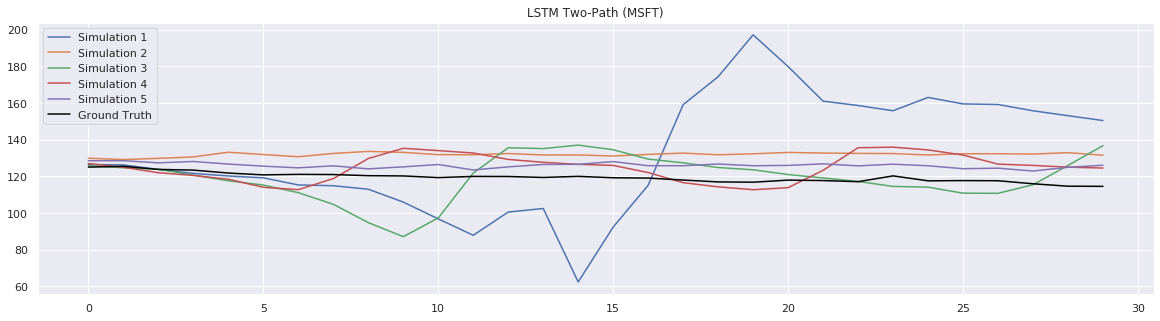

[70.49392991032417,
 89.13042711830717,
 89.50498344267982,
 92.15664968915979,
 94.18753339653158]

In [14]:
acc3 = [calculate_accuracy(df['4. close'].iloc[-test_size:].values, r) for r in results3]
top_5_idx = np.argsort(acc3)[-5:]
results3 = [results3[i] for i in top_5_idx]
acc3 = [calculate_accuracy(df['4. close'].iloc[-test_size:].values, r) for r in results3]

plt.figure(figsize = (20, 5))
for no, r in enumerate(results3):
    plt.plot(r, label = 'Simulation %d'%(no + 1))
    
plt.plot(df['4. close'].iloc[-test_size:].values, label = 'Ground Truth', c = 'black')
plt.legend()
plt.title('LSTM Two-Path (MSFT)')
plt.show()
acc3

In [66]:
class GRU:
    def __init__(
        self,
        learning_rate,
        num_layers,
        size,
        size_layer,
        output_size,
        forget_bias = 0.1,
    ):
        def lstm_cell(size_layer):
            return tf.nn.rnn_cell.GRUCell(size_layer)

        rnn_cells = tf.nn.rnn_cell.MultiRNNCell(
            [lstm_cell(size_layer) for _ in range(num_layers)],
            state_is_tuple = False,
        )
        self.X = tf.placeholder(tf.float32, (None, None, size))
        self.Y = tf.placeholder(tf.float32, (None, output_size))
        drop = tf.contrib.rnn.DropoutWrapper(
            rnn_cells, output_keep_prob = forget_bias
        )
        self.hidden_layer = tf.placeholder(
            tf.float32, (None, num_layers * size_layer)
        )
        self.outputs, self.last_state = tf.nn.dynamic_rnn(
            drop, self.X, initial_state = self.hidden_layer, dtype = tf.float32
        )
        self.logits = tf.layers.dense(self.outputs[-1], output_size)
        self.cost = tf.compat.v1.losses.mean_squared_error(self.Y, self.logits)
        self.optimizer = tf.train.AdamOptimizer(learning_rate).minimize(
            self.cost
        )

In [67]:
results4 = []
for i in range(simulation_size):
    print('simulation %d'%(i + 1))
    tf.reset_default_graph()
    modelnn = GRU(
        learning_rate, num_layers, df_log.shape[1], size_layer, df_log.shape[1], dropout_rate
    )
    sess = tf.InteractiveSession()
    sess.run(tf.global_variables_initializer())
    now = datetime.datetime.now()
    
    ## Training
    for i in range(epoch):
        init_value = np.zeros((1, num_layers * size_layer))
        total_loss, total_acc = [], []
        for k in range(0, df_train.shape[0] - 1, timestamp):
            index = min(k + timestamp, df_train.shape[0] - 1)
            batch_x = np.expand_dims(
                df_train.iloc[k : index, :].values, axis = 0
            )
            batch_y = df_train.iloc[k + 1 : index + 1, :].values
            logits, last_state, _, loss = sess.run(
                [modelnn.logits, modelnn.last_state, modelnn.optimizer, modelnn.cost],
                feed_dict = {
                    modelnn.X: batch_x,
                    modelnn.Y: batch_y,
                    modelnn.hidden_layer: init_value,
                },
            )        
            init_value = last_state
            total_loss.append(loss)
            total_acc.append(calculate_accuracy(batch_y[:, 0], logits[:, 0]))
    
    fin = datetime.datetime.now()
    print(fin-now)
    
    ## Testing
    future_day = test_size

    output_predict = np.zeros((df_train.shape[0] + future_day, df_train.shape[1]))
    output_predict[0] = df_train.iloc[0]
    upper_b = (df_train.shape[0] // timestamp) * timestamp
    init_value = np.zeros((1, num_layers * size_layer))

    for k in range(0, (df_train.shape[0] // timestamp) * timestamp, timestamp):
        out_logits, last_state = sess.run(
            [modelnn.logits, modelnn.last_state],
            feed_dict = {
                modelnn.X: np.expand_dims(
                    df_train.iloc[k : k + timestamp], axis = 0
                ),
                modelnn.hidden_layer: init_value,
            },
        )
        init_value = last_state
        output_predict[k + 1 : k + timestamp + 1] = out_logits

    if upper_b != df_train.shape[0]:
        out_logits, last_state = sess.run(
            [modelnn.logits, modelnn.last_state],
            feed_dict = {
                modelnn.X: np.expand_dims(df_train.iloc[upper_b:], axis = 0),
                modelnn.hidden_layer: init_value,
            },
        )
        output_predict[upper_b + 1 : df_train.shape[0] + 1] = out_logits
        future_day -= 1

    init_value = last_state
    
    for i in range(future_day):
        o = output_predict[-future_day - timestamp + i:-future_day + i]
        out_logits, last_state = sess.run(
            [modelnn.logits, modelnn.last_state],
            feed_dict = {
                modelnn.X: np.expand_dims(o, axis = 0),
                modelnn.hidden_layer: init_value,
            },
        )
        init_value = last_state
        output_predict[-future_day + i] = out_logits[-1]
    
    output_predict = minmax.inverse_transform(output_predict)
    deep_future = anchor(output_predict[:, 0], 0.3)
    
    results4.append(deep_future[-test_size:])

simulation 1
0:03:26.096084
simulation 2
0:03:29.557537
simulation 3
0:03:29.332010
simulation 4
0:03:26.577387
simulation 5
0:03:29.126783


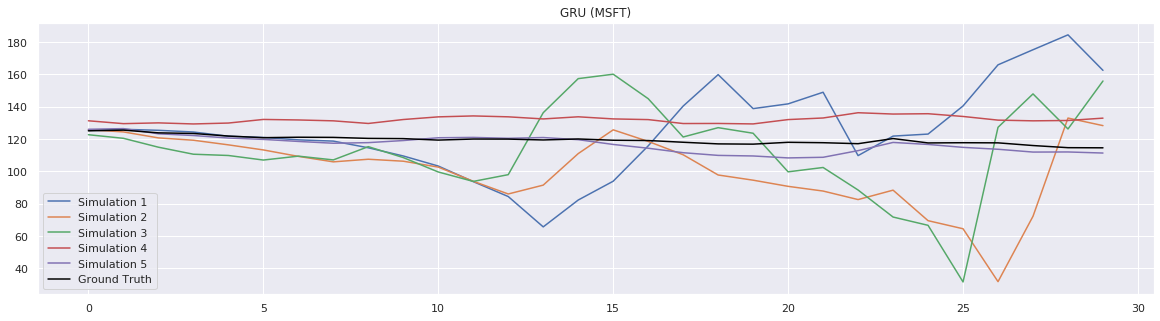

In [68]:
acc4 = [calculate_accuracy(df['4. close'].iloc[-test_size:].values, r) for r in results4]
top_5_idx = np.argsort(acc4)[-5:]
results4 = [results4[i] for i in top_5_idx]
acc4 = [calculate_accuracy(df['4. close'].iloc[-test_size:].values, r) for r in results4]

plt.figure(figsize = (20, 5))
for no, r in enumerate(results4):
    plt.plot(r, label = 'Simulation %d'%(no + 1))
    
plt.plot(df['4. close'].iloc[-test_size:].values, label = 'Ground Truth', c = 'black')
plt.legend()
plt.title('GRU (MSFT)')
plt.show()

In [69]:
class GRU_bid:
    def __init__(
        self,
        learning_rate,
        num_layers,
        size,
        size_layer,
        output_size,
        forget_bias = 0.1,
    ):
        def lstm_cell(size_layer):
            return tf.nn.rnn_cell.GRUCell(size_layer)

        backward_rnn_cells = tf.nn.rnn_cell.MultiRNNCell(
            [lstm_cell(size_layer) for _ in range(num_layers)],
            state_is_tuple = False,
        )
        forward_rnn_cells = tf.nn.rnn_cell.MultiRNNCell(
            [lstm_cell(size_layer) for _ in range(num_layers)],
            state_is_tuple = False,
        )
        self.X = tf.placeholder(tf.float32, (None, None, size))
        self.Y = tf.placeholder(tf.float32, (None, output_size))
        drop_backward = tf.contrib.rnn.DropoutWrapper(
            backward_rnn_cells, output_keep_prob = forget_bias
        )
        forward_backward = tf.contrib.rnn.DropoutWrapper(
            forward_rnn_cells, output_keep_prob = forget_bias
        )
        self.backward_hidden_layer = tf.placeholder(
            tf.float32, shape = (None, num_layers * size_layer)
        )
        self.forward_hidden_layer = tf.placeholder(
            tf.float32, shape = (None, num_layers * size_layer)
        )
        self.outputs, self.last_state = tf.nn.bidirectional_dynamic_rnn(
            forward_backward,
            drop_backward,
            self.X,
            initial_state_fw = self.forward_hidden_layer,
            initial_state_bw = self.backward_hidden_layer,
            dtype = tf.float32,
        )
        self.outputs = tf.concat(self.outputs, 2)
        self.logits = tf.layers.dense(self.outputs[-1], output_size)
        self.cost = tf.compat.v1.losses.mean_squared_error(self.Y, self.logits)
        self.optimizer = tf.train.AdamOptimizer(learning_rate).minimize(
            self.cost
        )

In [70]:
results5 = []
for i in range(simulation_size):
    print('simulation %d'%(i + 1))
    tf.reset_default_graph()
    modelnn = GRU_bid(
        learning_rate, num_layers, df_log.shape[1], size_layer, df_log.shape[1], dropout_rate
    )
    sess = tf.InteractiveSession()
    sess.run(tf.global_variables_initializer())
    now = datetime.datetime.now()
    
    ## Training
    for i in range(epoch):
        init_value_forward = np.zeros((1, num_layers * size_layer))
        init_value_backward = np.zeros((1, num_layers * size_layer))
        total_loss, total_acc = [], []
        for k in range(0, df_train.shape[0] - 1, timestamp):
            index = min(k + timestamp, df_train.shape[0] - 1)
            batch_x = np.expand_dims(
                df_train.iloc[k : index, :].values, axis = 0
            )
            batch_y = df_train.iloc[k + 1 : index + 1, :].values
            logits, last_state, _, loss = sess.run(
                [modelnn.logits, modelnn.last_state, modelnn.optimizer, modelnn.cost],
                feed_dict = {
                    modelnn.X: batch_x,
                    modelnn.Y: batch_y,
                    modelnn.backward_hidden_layer: init_value_backward,
                    modelnn.forward_hidden_layer: init_value_forward,
                },
            )        
            init_value_forward = last_state[0]
            init_value_backward = last_state[1]
            total_loss.append(loss)
            total_acc.append(calculate_accuracy(batch_y[:, 0], logits[:, 0]))
    
    fin = datetime.datetime.now()
    print(fin-now)
    
    ## Testing
    future_day = test_size

    output_predict = np.zeros((df_train.shape[0] + future_day, df_train.shape[1]))
    output_predict[0] = df_train.iloc[0]
    upper_b = (df_train.shape[0] // timestamp) * timestamp
    init_value_forward = np.zeros((1, num_layers * size_layer))
    init_value_backward = np.zeros((1, num_layers * size_layer))

    for k in range(0, (df_train.shape[0] // timestamp) * timestamp, timestamp):
        out_logits, last_state = sess.run(
            [modelnn.logits, modelnn.last_state],
            feed_dict = {
                modelnn.X: np.expand_dims(
                    df_train.iloc[k : k + timestamp], axis = 0
                ),
                modelnn.backward_hidden_layer: init_value_backward,
                modelnn.forward_hidden_layer: init_value_forward,
            },
        )
        init_value_forward = last_state[0]
        init_value_backward = last_state[1]
        output_predict[k + 1 : k + timestamp + 1] = out_logits

    if upper_b != df_train.shape[0]:
        out_logits, last_state = sess.run(
            [modelnn.logits, modelnn.last_state],
            feed_dict = {
                modelnn.X: np.expand_dims(df_train.iloc[upper_b:], axis = 0),
                modelnn.backward_hidden_layer: init_value_backward,
                modelnn.forward_hidden_layer: init_value_forward,
            },
        )
        output_predict[upper_b + 1 : df_train.shape[0] + 1] = out_logits
        future_day -= 1

    init_value_forward = last_state[0]
    init_value_backward = last_state[1]
    
    for i in range(future_day):
        o = output_predict[-future_day - timestamp + i:-future_day + i]
        out_logits, last_state = sess.run(
            [modelnn.logits, modelnn.last_state],
            feed_dict = {
                modelnn.X: np.expand_dims(o, axis = 0),
                modelnn.backward_hidden_layer: init_value_backward,
                modelnn.forward_hidden_layer: init_value_forward,
            },
        )
        init_value_forward = last_state[0]
        init_value_backward = last_state[1]
        output_predict[-future_day + i] = out_logits[-1]
    
    output_predict = minmax.inverse_transform(output_predict)
    deep_future = anchor(output_predict[:, 0], 0.3)
    
    results5.append(deep_future[-test_size:])

simulation 1
0:05:00.745348
simulation 2
0:04:57.848584
simulation 3
0:04:58.679034
simulation 4
0:04:58.530801
simulation 5
0:04:56.247869


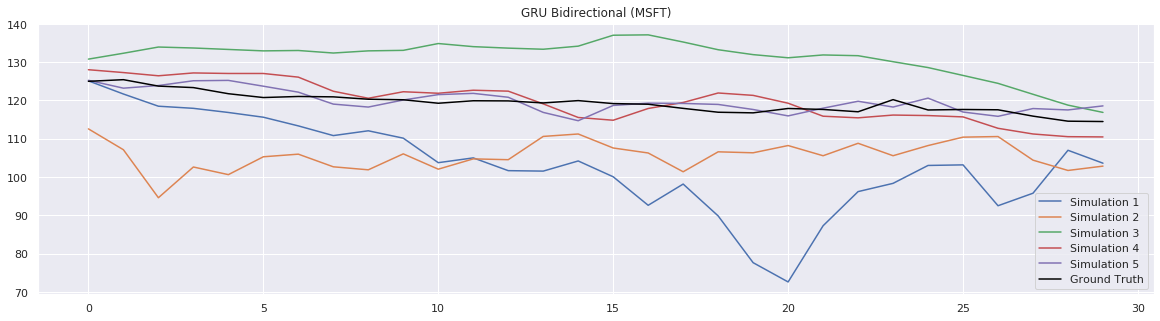

In [71]:
acc5 = [calculate_accuracy(df['4. close'].iloc[-test_size:].values, r) for r in results5]
top_5_idx = np.argsort(acc5)[-5:]
results5 = [results5[i] for i in top_5_idx]
acc5 = [calculate_accuracy(df['4. close'].iloc[-test_size:].values, r) for r in results5]

plt.figure(figsize = (20, 5))
for no, r in enumerate(results5):
    plt.plot(r, label = 'Simulation %d'%(no + 1))
    
plt.plot(df['4. close'].iloc[-test_size:].values, label = 'Ground Truth', c = 'black')
plt.legend()
plt.title('GRU Bidirectional (MSFT)')
plt.show()

In [72]:
class GRU_sum:
    def __init__(
        self,
        learning_rate,
        num_layers,
        size,
        size_layer,
        output_size,
        forget_bias = 0.1,
    ):
        def lstm_cell(size_layer):
            return tf.nn.rnn_cell.GRUCell(size_layer)
        
        with tf.variable_scope('forward', reuse = False):
            rnn_cells_forward = tf.nn.rnn_cell.MultiRNNCell(
                [lstm_cell(size_layer) for _ in range(num_layers)],
                state_is_tuple = False,
            )
            self.X_forward = tf.placeholder(tf.float32, (None, None, size))
            drop_forward = tf.contrib.rnn.DropoutWrapper(
                rnn_cells_forward, output_keep_prob = forget_bias
            )
            self.hidden_layer_forward = tf.placeholder(
                tf.float32, (None, num_layers * size_layer)
            )
            self.outputs_forward, self.last_state_forward = tf.nn.dynamic_rnn(
                drop_forward,
                self.X_forward,
                initial_state = self.hidden_layer_forward,
                dtype = tf.float32,
            )

        with tf.variable_scope('backward', reuse = False):
            rnn_cells_backward = tf.nn.rnn_cell.MultiRNNCell(
                [lstm_cell(size_layer) for _ in range(num_layers)],
                state_is_tuple = False,
            )
            self.X_backward = tf.placeholder(tf.float32, (None, None, size))
            drop_backward = tf.contrib.rnn.DropoutWrapper(
                rnn_cells_backward, output_keep_prob = forget_bias
            )
            self.hidden_layer_backward = tf.placeholder(
                tf.float32, (None, num_layers * size_layer)
            )
            self.outputs_backward, self.last_state_backward = tf.nn.dynamic_rnn(
                drop_backward,
                self.X_backward,
                initial_state = self.hidden_layer_backward,
                dtype = tf.float32,
            )

        self.outputs = self.outputs_backward + self.outputs_forward
        self.Y = tf.placeholder(tf.float32, (None, output_size))
        self.logits = tf.layers.dense(self.outputs[-1], output_size)
        self.cost = tf.compat.v1.losses.mean_squared_error(self.Y, self.logits)
        self.optimizer = tf.train.AdamOptimizer(learning_rate).minimize(
            self.cost
        )

In [73]:
results6 = []
for i in range(simulation_size):
    print('simulation %d'%(i + 1))
    tf.reset_default_graph()
    modelnn = GRU_sum(
        learning_rate, num_layers, df_log.shape[1], size_layer, df_log.shape[1], dropout_rate
    )
    sess = tf.InteractiveSession()
    sess.run(tf.global_variables_initializer())
    now = datetime.datetime.now()
    
    ## Training
    for i in range(epoch):
        init_value_forward = np.zeros((1, num_layers * size_layer))
        init_value_backward = np.zeros((1, num_layers * size_layer))
        total_loss, total_acc = [], []
        for k in range(0, df_train.shape[0] - 1, timestamp):
            index = min(k + timestamp, df_train.shape[0] - 1)
            batch_x_forward = np.expand_dims(
                df_train.iloc[k : index, :].values, axis = 0
            )
            batch_x_backward = np.expand_dims(
                np.flip(df_train.iloc[k : index, :].values, axis = 0), axis = 0
            )
            batch_y = df_train.iloc[k + 1 : index + 1, :].values
            logits, last_state_forward, last_state_backward, _, loss = sess.run(
                [
                    modelnn.logits,
                    modelnn.last_state_forward,
                    modelnn.last_state_backward,
                    modelnn.optimizer,
                    modelnn.cost,
                ],
                feed_dict = {
                    modelnn.X_forward: batch_x_forward,
                    modelnn.X_backward: batch_x_backward,
                    modelnn.Y: batch_y,
                    modelnn.hidden_layer_forward: init_value_forward,
                    modelnn.hidden_layer_backward: init_value_backward,
                },
            )
            init_value_forward = last_state_forward
            init_value_backward = last_state_backward
            total_loss.append(loss)
            total_acc.append(calculate_accuracy(batch_y[:, 0], logits[:, 0]))
    
    fin = datetime.datetime.now()
    print(fin-now)
    
    ## Testing
    future_day = test_size

    output_predict = np.zeros((df_train.shape[0] + future_day, df_train.shape[1]))
    output_predict[0] = df_train.iloc[0]
    upper_b = (df_train.shape[0] // timestamp) * timestamp
    init_value_forward = np.zeros((1, num_layers * size_layer))
    init_value_backward = np.zeros((1, num_layers * size_layer))

    for k in range(0, (df_train.shape[0] // timestamp) * timestamp, timestamp):
        batch_x_forward = np.expand_dims(
        df_train.iloc[k : k + timestamp, :], axis = 0
        )
        batch_x_backward = np.expand_dims(
            np.flip(df_train.iloc[k : k + timestamp, :].values, axis = 0), axis = 0
        )
        out_logits, last_state_forward, last_state_backward = sess.run(
            [
                modelnn.logits,
                modelnn.last_state_forward,
                modelnn.last_state_backward,
            ],
            feed_dict = {
                modelnn.X_forward: batch_x_forward,
                modelnn.X_backward: batch_x_backward,
                modelnn.hidden_layer_forward: init_value_forward,
                modelnn.hidden_layer_backward: init_value_backward,
            },
        )
        init_value_forward = last_state_forward
        init_value_backward = last_state_backward
        output_predict[k + 1 : k + timestamp + 1, :] = out_logits

    if upper_b != df_train.shape[0]:
        batch_x_forward = np.expand_dims(df_train.iloc[upper_b:, :], axis = 0)
        batch_x_backward = np.expand_dims(
            np.flip(df_train.iloc[upper_b:, :].values, axis = 0), axis = 0
        )
        out_logits, last_state_forward, last_state_backward = sess.run(
            [modelnn.logits, modelnn.last_state_forward, modelnn.last_state_backward],
            feed_dict = {
                modelnn.X_forward: batch_x_forward,
                modelnn.X_backward: batch_x_backward,
                modelnn.hidden_layer_forward: init_value_forward,
                modelnn.hidden_layer_backward: init_value_backward,
            },
        )
        init_value_forward = last_state_forward
        init_value_backward = last_state_backward
        output_predict[upper_b + 1 : df_train.shape[0] + 1] = out_logits
        future_day -= 1
        
    init_value_forward = last_state_forward
    init_value_backward = last_state_backward
    
    for i in range(future_day):
        o = output_predict[-future_day - timestamp + i:-future_day + i]
        o_f = np.flip(o, axis = 0)
        out_logits, last_state_forward, last_state_backward = sess.run(
            [
                modelnn.logits,
                modelnn.last_state_forward,
                modelnn.last_state_backward,
            ],
            feed_dict = {
                modelnn.X_forward: np.expand_dims(o, axis = 0),
                modelnn.X_backward: np.expand_dims(o_f, axis = 0),
                modelnn.hidden_layer_forward: init_value_forward,
                modelnn.hidden_layer_backward: init_value_backward,
            },
        )
        init_value_forward = last_state_forward
        init_value_backward = last_state_backward
        output_predict[-future_day + i] = out_logits[-1]
    
    output_predict = minmax.inverse_transform(output_predict)
    deep_future = anchor(output_predict[:, 0], 0.3)
    
    results6.append(deep_future[-test_size:])

simulation 1
0:05:10.571355
simulation 2
0:05:39.760054
simulation 3
0:05:33.124773
simulation 4
0:05:29.858559
simulation 5
0:05:40.852273


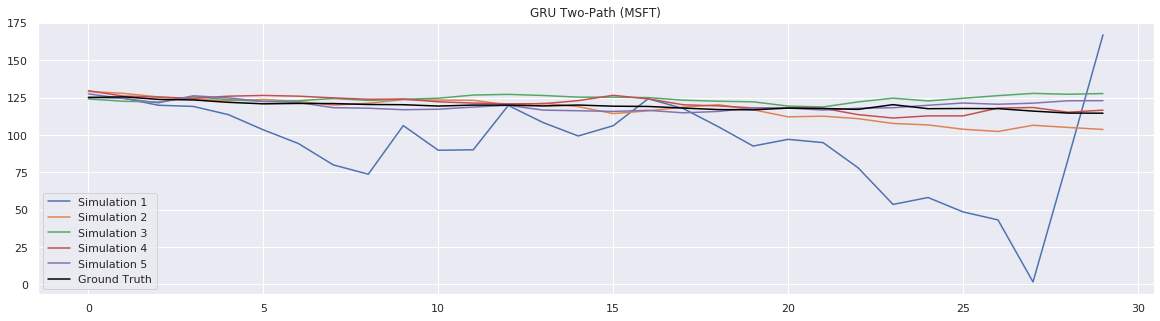

In [74]:
acc6 = [calculate_accuracy(df['4. close'].iloc[-test_size:].values, r) for r in results6]
top_5_idx = np.argsort(acc6)[-5:]
results6 = [results6[i] for i in top_5_idx]
acc6 = [calculate_accuracy(df['4. close'].iloc[-test_size:].values, r) for r in results6]

plt.figure(figsize = (20, 5))
for no, r in enumerate(results6):
    plt.plot(r, label = 'Simulation %d'%(no + 1))
    
plt.plot(df['4. close'].iloc[-test_size:].values, label = 'Ground Truth', c = 'black')
plt.legend()
plt.title('GRU Two-Path (MSFT)')
plt.show()

In [75]:
class VanillaRNN:
    def __init__(
        self,
        learning_rate,
        num_layers,
        size,
        size_layer,
        output_size,
        forget_bias = 0.1,
    ):
        def lstm_cell(size_layer):
            return tf.nn.rnn_cell.BasicRNNCell(size_layer)

        rnn_cells = tf.nn.rnn_cell.MultiRNNCell(
            [lstm_cell(size_layer) for _ in range(num_layers)],
            state_is_tuple = False,
        )
        self.X = tf.placeholder(tf.float32, (None, None, size))
        self.Y = tf.placeholder(tf.float32, (None, output_size))
        drop = tf.contrib.rnn.DropoutWrapper(
            rnn_cells, output_keep_prob = forget_bias
        )
        self.hidden_layer = tf.placeholder(
            tf.float32, (None, num_layers * size_layer)
        )
        self.outputs, self.last_state = tf.nn.dynamic_rnn(
            drop, self.X, initial_state = self.hidden_layer, dtype = tf.float32
        )
        self.logits = tf.layers.dense(self.outputs[-1], output_size)
        self.cost = tf.compat.v1.losses.mean_squared_error(self.Y, self.logits)
        self.optimizer = tf.train.AdamOptimizer(learning_rate).minimize(
            self.cost
        )

In [76]:
results7 = []
for i in range(simulation_size):
    print('simulation %d'%(i + 1))
    tf.reset_default_graph()
    modelnn = VanillaRNN(
        learning_rate, num_layers, df_log.shape[1], size_layer, df_log.shape[1], dropout_rate
    )
    sess = tf.InteractiveSession()
    sess.run(tf.global_variables_initializer())
    now = datetime.datetime.now()
    
    ## Training
    for i in range(epoch):
        init_value = np.zeros((1, num_layers * size_layer))
        total_loss, total_acc = [], []
        for k in range(0, df_train.shape[0] - 1, timestamp):
            index = min(k + timestamp, df_train.shape[0] - 1)
            batch_x = np.expand_dims(
                df_train.iloc[k : index, :].values, axis = 0
            )
            batch_y = df_train.iloc[k + 1 : index + 1, :].values
            logits, last_state, _, loss = sess.run(
                [modelnn.logits, modelnn.last_state, modelnn.optimizer, modelnn.cost],
                feed_dict = {
                    modelnn.X: batch_x,
                    modelnn.Y: batch_y,
                    modelnn.hidden_layer: init_value,
                },
            )        
            init_value = last_state
            total_loss.append(loss)
            total_acc.append(calculate_accuracy(batch_y[:, 0], logits[:, 0]))
    
    fin = datetime.datetime.now()
    print(fin-now)
    
    ## Testing
    future_day = test_size

    output_predict = np.zeros((df_train.shape[0] + future_day, df_train.shape[1]))
    output_predict[0] = df_train.iloc[0]
    upper_b = (df_train.shape[0] // timestamp) * timestamp
    init_value = np.zeros((1, num_layers * size_layer))

    for k in range(0, (df_train.shape[0] // timestamp) * timestamp, timestamp):
        out_logits, last_state = sess.run(
            [modelnn.logits, modelnn.last_state],
            feed_dict = {
                modelnn.X: np.expand_dims(
                    df_train.iloc[k : k + timestamp], axis = 0
                ),
                modelnn.hidden_layer: init_value,
            },
        )
        init_value = last_state
        output_predict[k + 1 : k + timestamp + 1] = out_logits

    if upper_b != df_train.shape[0]:
        out_logits, last_state = sess.run(
            [modelnn.logits, modelnn.last_state],
            feed_dict = {
                modelnn.X: np.expand_dims(df_train.iloc[upper_b:], axis = 0),
                modelnn.hidden_layer: init_value,
            },
        )
        output_predict[upper_b + 1 : df_train.shape[0] + 1] = out_logits
        future_day -= 1

    init_value = last_state
    
    for i in range(future_day):
        o = output_predict[-future_day - timestamp + i:-future_day + i]
        out_logits, last_state = sess.run(
            [modelnn.logits, modelnn.last_state],
            feed_dict = {
                modelnn.X: np.expand_dims(o, axis = 0),
                modelnn.hidden_layer: init_value,
            },
        )
        init_value = last_state
        output_predict[-future_day + i] = out_logits[-1]
    
    output_predict = minmax.inverse_transform(output_predict)
    deep_future = anchor(output_predict[:, 0], 0.3)
    
    results7.append(deep_future[-test_size:])

W0315 01:36:45.312296 140339716040512 deprecation.py:323] From <ipython-input-75-5e6f446929ac>:12: BasicRNNCell.__init__ (from tensorflow.python.ops.rnn_cell_impl) is deprecated and will be removed in a future version.
Instructions for updating:
This class is equivalent as tf.keras.layers.SimpleRNNCell, and will be replaced by that in Tensorflow 2.0.


simulation 1
0:03:09.698140
simulation 2
0:03:05.115232
simulation 3
0:03:15.998762
simulation 4
0:03:13.512380
simulation 5
0:03:07.925627


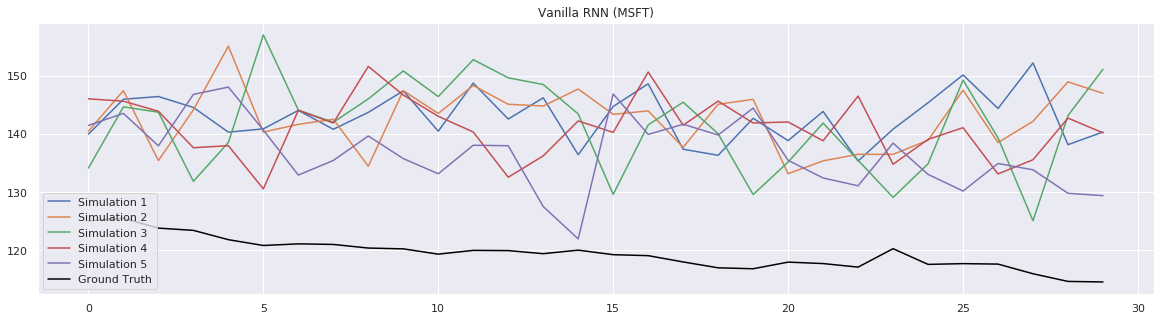

In [77]:
acc7 = [calculate_accuracy(df['4. close'].iloc[-test_size:].values, r) for r in results7]
top_5_idx = np.argsort(acc7)[-5:]
results7 = [results7[i] for i in top_5_idx]
acc7 = [calculate_accuracy(df['4. close'].iloc[-test_size:].values, r) for r in results7]

plt.figure(figsize = (20, 5))
for no, r in enumerate(results7):
    plt.plot(r, label = 'Simulation %d'%(no + 1))
    
plt.plot(df['4. close'].iloc[-test_size:].values, label = 'Ground Truth', c = 'black')
plt.legend()
plt.title('Vanilla RNN (MSFT)')
plt.show()

In [78]:
class VanillaRNN_bid:
    def __init__(
        self,
        learning_rate,
        num_layers,
        size,
        size_layer,
        output_size,
        forget_bias = 0.1,
    ):
        def lstm_cell(size_layer):
            return tf.nn.rnn_cell.BasicRNNCell(size_layer)

        backward_rnn_cells = tf.nn.rnn_cell.MultiRNNCell(
            [lstm_cell(size_layer) for _ in range(num_layers)],
            state_is_tuple = False,
        )
        forward_rnn_cells = tf.nn.rnn_cell.MultiRNNCell(
            [lstm_cell(size_layer) for _ in range(num_layers)],
            state_is_tuple = False,
        )
        self.X = tf.placeholder(tf.float32, (None, None, size))
        self.Y = tf.placeholder(tf.float32, (None, output_size))
        drop_backward = tf.contrib.rnn.DropoutWrapper(
            backward_rnn_cells, output_keep_prob = forget_bias
        )
        forward_backward = tf.contrib.rnn.DropoutWrapper(
            forward_rnn_cells, output_keep_prob = forget_bias
        )
        self.backward_hidden_layer = tf.placeholder(
            tf.float32, shape = (None, num_layers * size_layer)
        )
        self.forward_hidden_layer = tf.placeholder(
            tf.float32, shape = (None, num_layers * size_layer)
        )
        self.outputs, self.last_state = tf.nn.bidirectional_dynamic_rnn(
            forward_backward,
            drop_backward,
            self.X,
            initial_state_fw = self.forward_hidden_layer,
            initial_state_bw = self.backward_hidden_layer,
            dtype = tf.float32,
        )
        self.outputs = tf.concat(self.outputs, 2)
        self.logits = tf.layers.dense(self.outputs[-1], output_size)
        self.cost = tf.compat.v1.losses.mean_squared_error(self.Y, self.logits)
        self.optimizer = tf.train.AdamOptimizer(learning_rate).minimize(
            self.cost
        )

In [79]:
results8 = []
for i in range(simulation_size):
    print('simulation %d'%(i + 1))
    tf.reset_default_graph()
    modelnn = VanillaRNN_bid(
        learning_rate, num_layers, df_log.shape[1], size_layer, df_log.shape[1], dropout_rate
    )
    sess = tf.InteractiveSession()
    sess.run(tf.global_variables_initializer())
    now = datetime.datetime.now()
    
    ## Training
    for i in range(epoch):
        init_value_forward = np.zeros((1, num_layers * size_layer))
        init_value_backward = np.zeros((1, num_layers * size_layer))
        total_loss, total_acc = [], []
        for k in range(0, df_train.shape[0] - 1, timestamp):
            index = min(k + timestamp, df_train.shape[0] - 1)
            batch_x = np.expand_dims(
                df_train.iloc[k : index, :].values, axis = 0
            )
            batch_y = df_train.iloc[k + 1 : index + 1, :].values
            logits, last_state, _, loss = sess.run(
                [modelnn.logits, modelnn.last_state, modelnn.optimizer, modelnn.cost],
                feed_dict = {
                    modelnn.X: batch_x,
                    modelnn.Y: batch_y,
                    modelnn.backward_hidden_layer: init_value_backward,
                    modelnn.forward_hidden_layer: init_value_forward,
                },
            )        
            init_value_forward = last_state[0]
            init_value_backward = last_state[1]
            total_loss.append(loss)
            total_acc.append(calculate_accuracy(batch_y[:, 0], logits[:, 0]))
    
    fin = datetime.datetime.now()
    print(fin-now)
    
    ## Testing
    future_day = test_size

    output_predict = np.zeros((df_train.shape[0] + future_day, df_train.shape[1]))
    output_predict[0] = df_train.iloc[0]
    upper_b = (df_train.shape[0] // timestamp) * timestamp
    init_value_forward = np.zeros((1, num_layers * size_layer))
    init_value_backward = np.zeros((1, num_layers * size_layer))

    for k in range(0, (df_train.shape[0] // timestamp) * timestamp, timestamp):
        out_logits, last_state = sess.run(
            [modelnn.logits, modelnn.last_state],
            feed_dict = {
                modelnn.X: np.expand_dims(
                    df_train.iloc[k : k + timestamp], axis = 0
                ),
                modelnn.backward_hidden_layer: init_value_backward,
                modelnn.forward_hidden_layer: init_value_forward,
            },
        )
        init_value_forward = last_state[0]
        init_value_backward = last_state[1]
        output_predict[k + 1 : k + timestamp + 1] = out_logits

    if upper_b != df_train.shape[0]:
        out_logits, last_state = sess.run(
            [modelnn.logits, modelnn.last_state],
            feed_dict = {
                modelnn.X: np.expand_dims(df_train.iloc[upper_b:], axis = 0),
                modelnn.backward_hidden_layer: init_value_backward,
                modelnn.forward_hidden_layer: init_value_forward,
            },
        )
        output_predict[upper_b + 1 : df_train.shape[0] + 1] = out_logits
        future_day -= 1

    init_value_forward = last_state[0]
    init_value_backward = last_state[1]
    
    for i in range(future_day):
        o = output_predict[-future_day - timestamp + i:-future_day + i]
        out_logits, last_state = sess.run(
            [modelnn.logits, modelnn.last_state],
            feed_dict = {
                modelnn.X: np.expand_dims(o, axis = 0),
                modelnn.backward_hidden_layer: init_value_backward,
                modelnn.forward_hidden_layer: init_value_forward,
            },
        )
        init_value_forward = last_state[0]
        init_value_backward = last_state[1]
        output_predict[-future_day + i] = out_logits[-1]
    
    output_predict = minmax.inverse_transform(output_predict)
    deep_future = anchor(output_predict[:, 0], 0.3)
    
    results8.append(deep_future[-test_size:])

simulation 1
0:03:33.685505
simulation 2
0:03:33.115194
simulation 3
0:03:31.806234
simulation 4
0:03:34.179727
simulation 5
0:03:43.681113


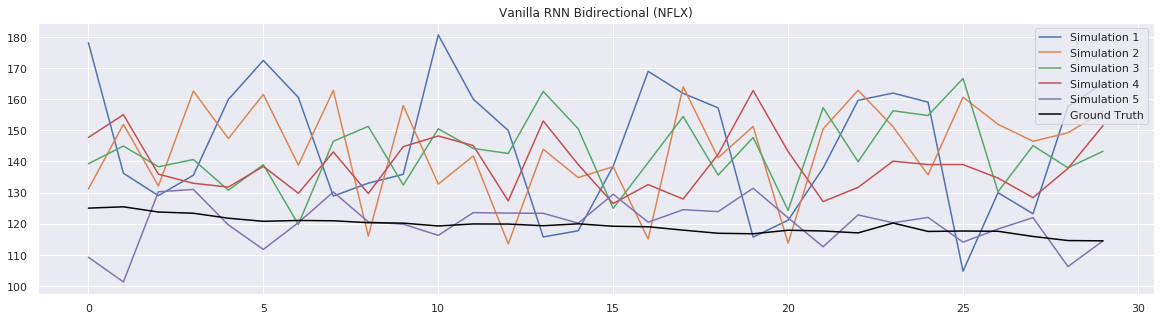

In [80]:
acc8 = [calculate_accuracy(df['4. close'].iloc[-test_size:].values, r) for r in results8]
top_5_idx = np.argsort(acc8)[-5:]
results8 = [results8[i] for i in top_5_idx]
acc8 = [calculate_accuracy(df['4. close'].iloc[-test_size:].values, r) for r in results8]

plt.figure(figsize = (20, 5))
for no, r in enumerate(results8):
    plt.plot(r, label = 'Simulation %d'%(no + 1))
    
plt.plot(df['4. close'].iloc[-test_size:].values, label = 'Ground Truth', c = 'black')
plt.legend()
plt.title('Vanilla RNN Bidirectional (NFLX)')
plt.show()

In [83]:
class VanillaRNN_sum:
    def __init__(
        self,
        learning_rate,
        num_layers,
        size,
        size_layer,
        output_size,
        forget_bias = 0.1,
    ):
        def lstm_cell(size_layer):
            return tf.nn.rnn_cell.BasicRNNCell(size_layer)
        
        with tf.variable_scope('forward', reuse = False):
            rnn_cells_forward = tf.nn.rnn_cell.MultiRNNCell(
                [lstm_cell(size_layer) for _ in range(num_layers)],
                state_is_tuple = False,
            )
            self.X_forward = tf.placeholder(tf.float32, (None, None, size))
            drop_forward = tf.contrib.rnn.DropoutWrapper(
                rnn_cells_forward, output_keep_prob = forget_bias
            )
            self.hidden_layer_forward = tf.placeholder(
                tf.float32, (None, num_layers * size_layer)
            )
            self.outputs_forward, self.last_state_forward = tf.nn.dynamic_rnn(
                drop_forward,
                self.X_forward,
                initial_state = self.hidden_layer_forward,
                dtype = tf.float32,
            )

        with tf.variable_scope('backward', reuse = False):
            rnn_cells_backward = tf.nn.rnn_cell.MultiRNNCell(
                [lstm_cell(size_layer) for _ in range(num_layers)],
                state_is_tuple = False,
            )
            self.X_backward = tf.placeholder(tf.float32, (None, None, size))
            drop_backward = tf.contrib.rnn.DropoutWrapper(
                rnn_cells_backward, output_keep_prob = forget_bias
            )
            self.hidden_layer_backward = tf.placeholder(
                tf.float32, (None, num_layers * size_layer)
            )
            self.outputs_backward, self.last_state_backward = tf.nn.dynamic_rnn(
                drop_backward,
                self.X_backward,
                initial_state = self.hidden_layer_backward,
                dtype = tf.float32,
            )

        self.outputs = self.outputs_backward + self.outputs_forward
        self.Y = tf.placeholder(tf.float32, (None, output_size))
        self.logits = tf.layers.dense(self.outputs[-1], output_size)
        self.cost = tf.compat.v1.losses.mean_squared_error(self.Y, self.logits)
        self.optimizer = tf.train.AdamOptimizer(learning_rate).minimize(
            self.cost
        )

In [84]:
results9 = []
for i in range(simulation_size):
    print('simulation %d'%(i + 1))
    tf.reset_default_graph()
    modelnn = VanillaRNN_sum(
        learning_rate, num_layers, df_log.shape[1], size_layer, df_log.shape[1], dropout_rate
    )
    sess = tf.InteractiveSession()
    sess.run(tf.global_variables_initializer())
    now = datetime.datetime.now()
    
    ## Training
    for i in range(epoch):
        init_value_forward = np.zeros((1, num_layers * size_layer))
        init_value_backward = np.zeros((1, num_layers * size_layer))
        total_loss, total_acc = [], []
        for k in range(0, df_train.shape[0] - 1, timestamp):
            index = min(k + timestamp, df_train.shape[0] - 1)
            batch_x_forward = np.expand_dims(
                df_train.iloc[k : index, :].values, axis = 0
            )
            batch_x_backward = np.expand_dims(
                np.flip(df_train.iloc[k : index, :].values, axis = 0), axis = 0
            )
            batch_y = df_train.iloc[k + 1 : index + 1, :].values
            logits, last_state_forward, last_state_backward, _, loss = sess.run(
                [
                    modelnn.logits,
                    modelnn.last_state_forward,
                    modelnn.last_state_backward,
                    modelnn.optimizer,
                    modelnn.cost,
                ],
                feed_dict = {
                    modelnn.X_forward: batch_x_forward,
                    modelnn.X_backward: batch_x_backward,
                    modelnn.Y: batch_y,
                    modelnn.hidden_layer_forward: init_value_forward,
                    modelnn.hidden_layer_backward: init_value_backward,
                },
            )
            init_value_forward = last_state_forward
            init_value_backward = last_state_backward
            total_loss.append(loss)
            total_acc.append(calculate_accuracy(batch_y[:, 0], logits[:, 0]))
    
    fin = datetime.datetime.now()
    print(fin-now)
    
    ## Testing
    future_day = test_size

    output_predict = np.zeros((df_train.shape[0] + future_day, df_train.shape[1]))
    output_predict[0] = df_train.iloc[0]
    upper_b = (df_train.shape[0] // timestamp) * timestamp
    init_value_forward = np.zeros((1, num_layers * size_layer))
    init_value_backward = np.zeros((1, num_layers * size_layer))

    for k in range(0, (df_train.shape[0] // timestamp) * timestamp, timestamp):
        batch_x_forward = np.expand_dims(
        df_train.iloc[k : k + timestamp, :], axis = 0
        )
        batch_x_backward = np.expand_dims(
            np.flip(df_train.iloc[k : k + timestamp, :].values, axis = 0), axis = 0
        )
        out_logits, last_state_forward, last_state_backward = sess.run(
            [
                modelnn.logits,
                modelnn.last_state_forward,
                modelnn.last_state_backward,
            ],
            feed_dict = {
                modelnn.X_forward: batch_x_forward,
                modelnn.X_backward: batch_x_backward,
                modelnn.hidden_layer_forward: init_value_forward,
                modelnn.hidden_layer_backward: init_value_backward,
            },
        )
        init_value_forward = last_state_forward
        init_value_backward = last_state_backward
        output_predict[k + 1 : k + timestamp + 1, :] = out_logits

    if upper_b != df_train.shape[0]:
        batch_x_forward = np.expand_dims(df_train.iloc[upper_b:, :], axis = 0)
        batch_x_backward = np.expand_dims(
            np.flip(df_train.iloc[upper_b:, :].values, axis = 0), axis = 0
        )
        out_logits, last_state_forward, last_state_backward = sess.run(
            [modelnn.logits, modelnn.last_state_forward, modelnn.last_state_backward],
            feed_dict = {
                modelnn.X_forward: batch_x_forward,
                modelnn.X_backward: batch_x_backward,
                modelnn.hidden_layer_forward: init_value_forward,
                modelnn.hidden_layer_backward: init_value_backward,
            },
        )
        init_value_forward = last_state_forward
        init_value_backward = last_state_backward
        output_predict[upper_b + 1 : df_train.shape[0] + 1] = out_logits
        future_day -= 1

    init_value_forward = last_state_forward
    init_value_backward = last_state_backward
    
    for i in range(future_day):
        o = output_predict[-future_day - timestamp + i:-future_day + i]
        o_f = np.flip(o, axis = 0)
        out_logits, last_state_forward, last_state_backward = sess.run(
            [
                modelnn.logits,
                modelnn.last_state_forward,
                modelnn.last_state_backward,
            ],
            feed_dict = {
                modelnn.X_forward: np.expand_dims(o, axis = 0),
                modelnn.X_backward: np.expand_dims(o_f, axis = 0),
                modelnn.hidden_layer_forward: init_value_forward,
                modelnn.hidden_layer_backward: init_value_backward,
            },
        )
        init_value_forward = last_state_forward
        init_value_backward = last_state_backward
        output_predict[-future_day + i] = out_logits[-1]
    
    output_predict = minmax.inverse_transform(output_predict)
    deep_future = anchor(output_predict[:, 0], 0.3)
    
    results9.append(deep_future[-test_size:])

simulation 1
0:04:13.278527
simulation 2
0:04:27.382366
simulation 3
0:04:31.433739
simulation 4
0:04:30.230471
simulation 5
0:04:29.409614


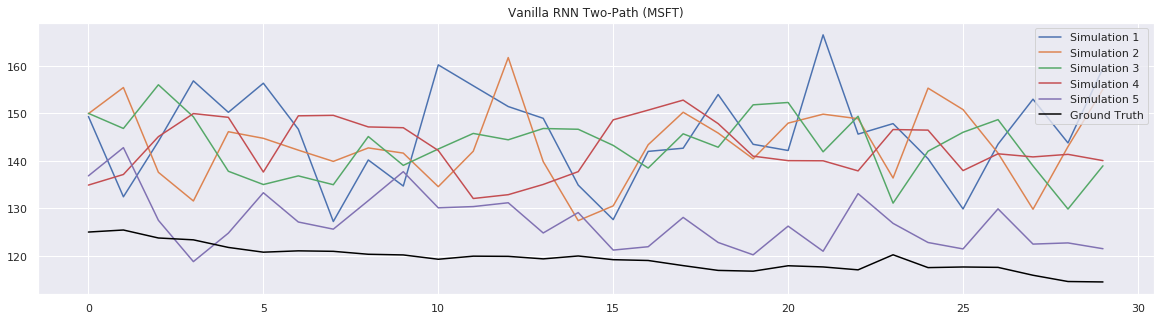

In [85]:
acc9 = [calculate_accuracy(df['4. close'].iloc[-test_size:].values, r) for r in results9]
top_5_idx = np.argsort(acc9)[-5:]
results9 = [results9[i] for i in top_5_idx]
acc9 = [calculate_accuracy(df['4. close'].iloc[-test_size:].values, r) for r in results9]

plt.figure(figsize = (20, 5))
for no, r in enumerate(results9):
    plt.plot(r, label = 'Simulation %d'%(no + 1))
    
plt.plot(df['4. close'].iloc[-test_size:].values, label = 'Ground Truth', c = 'black')
plt.legend()
plt.title('Vanilla RNN Two-Path (MSFT)')
plt.show()

In [86]:
class LSTM_seq2seq:
    def __init__(
        self,
        learning_rate,
        num_layers,
        size,
        size_layer,
        output_size,
        forget_bias = 0.1,
    ):
        def lstm_cell(size_layer):
            return tf.nn.rnn_cell.LSTMCell(size_layer, state_is_tuple = False)

        rnn_cells = tf.nn.rnn_cell.MultiRNNCell(
            [lstm_cell(size_layer) for _ in range(num_layers)],
            state_is_tuple = False,
        )
        self.X = tf.placeholder(tf.float32, (None, None, size))
        self.Y = tf.placeholder(tf.float32, (None, output_size))
        drop = tf.contrib.rnn.DropoutWrapper(
            rnn_cells, output_keep_prob = forget_bias
        )
        self.hidden_layer = tf.placeholder(
            tf.float32, (None, num_layers * 2 * size_layer)
        )
        _, last_state = tf.nn.dynamic_rnn(
            drop, self.X, initial_state = self.hidden_layer, dtype = tf.float32
        )
        
        with tf.variable_scope('decoder', reuse = False):
            rnn_cells_dec = tf.nn.rnn_cell.MultiRNNCell(
                [lstm_cell(size_layer) for _ in range(num_layers)], state_is_tuple = False
            )
            drop_dec = tf.contrib.rnn.DropoutWrapper(
                rnn_cells_dec, output_keep_prob = forget_bias
            )
            self.outputs, self.last_state = tf.nn.dynamic_rnn(
                drop_dec, self.X, initial_state = last_state, dtype = tf.float32
            )
            
        self.logits = tf.layers.dense(self.outputs[-1], output_size)
        self.cost = tf.compat.v1.losses.mean_squared_error(self.Y, self.logits)
        self.optimizer = tf.train.AdamOptimizer(learning_rate).minimize(
            self.cost
        )

In [87]:
results10 = []
for i in range(simulation_size):
    print('simulation %d'%(i + 1))
    tf.reset_default_graph()
    modelnn = LSTM_seq2seq(
        learning_rate, num_layers, df_log.shape[1], size_layer, df_log.shape[1], dropout_rate
    )
    sess = tf.InteractiveSession()
    sess.run(tf.global_variables_initializer())
    now = datetime.datetime.now()
    
    ## Training
    for i in range(epoch):
        init_value = np.zeros((1, num_layers * 2 * size_layer))
        total_loss, total_acc = [], []
        for k in range(0, df_train.shape[0] - 1, timestamp):
            index = min(k + timestamp, df_train.shape[0] - 1)
            batch_x = np.expand_dims(
                df_train.iloc[k : index, :].values, axis = 0
            )
            batch_y = df_train.iloc[k + 1 : index + 1, :].values
            logits, last_state, _, loss = sess.run(
                [modelnn.logits, modelnn.last_state, modelnn.optimizer, modelnn.cost],
                feed_dict = {
                    modelnn.X: batch_x,
                    modelnn.Y: batch_y,
                    modelnn.hidden_layer: init_value,
                },
            )        
            init_value = last_state
            total_loss.append(loss)
            total_acc.append(calculate_accuracy(batch_y[:, 0], logits[:, 0]))
    
    fin = datetime.datetime.now()
    print(fin-now)
    
    ## Testing
    future_day = test_size

    output_predict = np.zeros((df_train.shape[0] + future_day, df_train.shape[1]))
    output_predict[0] = df_train.iloc[0]
    upper_b = (df_train.shape[0] // timestamp) * timestamp
    init_value = np.zeros((1, num_layers * 2 * size_layer))

    for k in range(0, (df_train.shape[0] // timestamp) * timestamp, timestamp):
        out_logits, last_state = sess.run(
            [modelnn.logits, modelnn.last_state],
            feed_dict = {
                modelnn.X: np.expand_dims(
                    df_train.iloc[k : k + timestamp], axis = 0
                ),
                modelnn.hidden_layer: init_value,
            },
        )
        init_value = last_state
        output_predict[k + 1 : k + timestamp + 1] = out_logits

    if upper_b != df_train.shape[0]:
        out_logits, last_state = sess.run(
            [modelnn.logits, modelnn.last_state],
            feed_dict = {
                modelnn.X: np.expand_dims(df_train.iloc[upper_b:], axis = 0),
                modelnn.hidden_layer: init_value,
            },
        )
        output_predict[upper_b + 1 : df_train.shape[0] + 1] = out_logits
        future_day -= 1

    init_value = last_state
    
    for i in range(future_day):
        o = output_predict[-future_day - timestamp + i:-future_day + i]
        out_logits, last_state = sess.run(
            [modelnn.logits, modelnn.last_state],
            feed_dict = {
                modelnn.X: np.expand_dims(o, axis = 0),
                modelnn.hidden_layer: init_value,
            },
        )
        init_value = last_state
        output_predict[-future_day + i] = out_logits[-1]
    
    output_predict = minmax.inverse_transform(output_predict)
    deep_future = anchor(output_predict[:, 0], 0.3)
    
    results10.append(deep_future[-test_size:])

W0315 02:46:55.407298 140339716040512 rnn_cell_impl.py:893] <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x7f970d0e11d0>: Using a concatenated state is slower and will soon be deprecated.  Use state_is_tuple=True.
W0315 02:46:55.515397 140339716040512 rnn_cell_impl.py:893] <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x7f970d0e16a0>: Using a concatenated state is slower and will soon be deprecated.  Use state_is_tuple=True.


simulation 1
0:05:30.124827


W0315 02:52:27.298623 140339716040512 rnn_cell_impl.py:893] <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x7f98b0664a90>: Using a concatenated state is slower and will soon be deprecated.  Use state_is_tuple=True.
W0315 02:52:27.416079 140339716040512 rnn_cell_impl.py:893] <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x7f970c5879e8>: Using a concatenated state is slower and will soon be deprecated.  Use state_is_tuple=True.


simulation 2
0:05:27.846946


W0315 02:57:56.944426 140339716040512 rnn_cell_impl.py:893] <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x7f970c587828>: Using a concatenated state is slower and will soon be deprecated.  Use state_is_tuple=True.
W0315 02:57:57.078866 140339716040512 rnn_cell_impl.py:893] <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x7f96f6978898>: Using a concatenated state is slower and will soon be deprecated.  Use state_is_tuple=True.


simulation 3
0:05:13.915541


W0315 03:03:12.661054 140339716040512 rnn_cell_impl.py:893] <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x7f96f4d77a20>: Using a concatenated state is slower and will soon be deprecated.  Use state_is_tuple=True.
W0315 03:03:12.780742 140339716040512 rnn_cell_impl.py:893] <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x7f96f451bcf8>: Using a concatenated state is slower and will soon be deprecated.  Use state_is_tuple=True.


simulation 4
0:05:14.759312


W0315 03:08:29.166326 140339716040512 rnn_cell_impl.py:893] <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x7f96f40caef0>: Using a concatenated state is slower and will soon be deprecated.  Use state_is_tuple=True.
W0315 03:08:29.282682 140339716040512 rnn_cell_impl.py:893] <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x7f96ed885940>: Using a concatenated state is slower and will soon be deprecated.  Use state_is_tuple=True.


simulation 5
0:05:17.074738


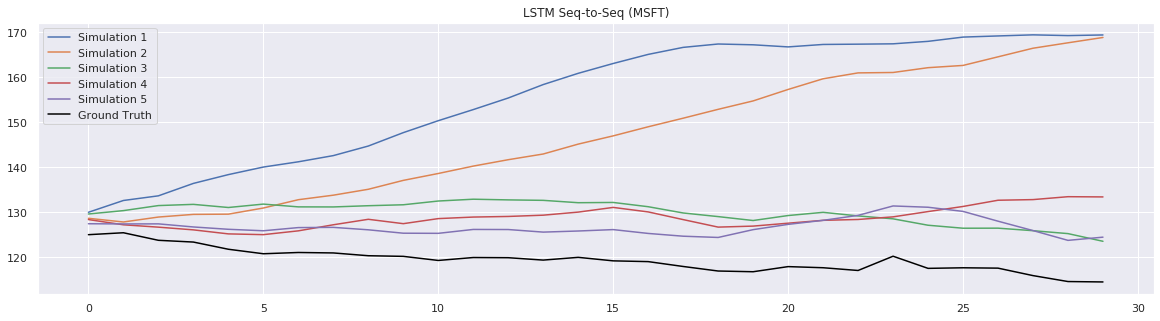

83.02787563612542

In [88]:
acc10 = [calculate_accuracy(df['4. close'].iloc[-test_size:].values, r) for r in results10]
top_5_idx = np.argsort(acc10)[-5:]
results10 = [results10[i] for i in top_5_idx]
acc10 = [calculate_accuracy(df['4. close'].iloc[-test_size:].values, r) for r in results10]

plt.figure(figsize = (20, 5))
for no, r in enumerate(results10):
    plt.plot(r, label = 'Simulation %d'%(no + 1))
    
plt.plot(df['4. close'].iloc[-test_size:].values, label = 'Ground Truth', c = 'black')
plt.legend()
plt.title('LSTM Seq-to-Seq (MSFT)')
plt.show()
np.mean(acc10)

In [89]:
class LSTM_seq2seq_bid:
    def __init__(
        self,
        learning_rate,
        num_layers,
        size,
        size_layer,
        output_size,
        forget_bias = 0.1,
    ):
        def lstm_cell(size_layer):
            return tf.nn.rnn_cell.LSTMCell(size_layer, state_is_tuple = False)

        backward_rnn_cells = tf.nn.rnn_cell.MultiRNNCell(
            [lstm_cell(size_layer) for _ in range(num_layers)],
            state_is_tuple = False,
        )
        forward_rnn_cells = tf.nn.rnn_cell.MultiRNNCell(
            [lstm_cell(size_layer) for _ in range(num_layers)],
            state_is_tuple = False,
        )
        self.X = tf.placeholder(tf.float32, (None, None, size))
        self.Y = tf.placeholder(tf.float32, (None, output_size))
        drop_backward = tf.contrib.rnn.DropoutWrapper(
            backward_rnn_cells, output_keep_prob = forget_bias
        )
        forward_backward = tf.contrib.rnn.DropoutWrapper(
            forward_rnn_cells, output_keep_prob = forget_bias
        )
        self.backward_hidden_layer = tf.placeholder(
            tf.float32, shape = (None, num_layers * 2 * size_layer)
        )
        self.forward_hidden_layer = tf.placeholder(
            tf.float32, shape = (None, num_layers * 2 * size_layer)
        )
        _, last_state = tf.nn.bidirectional_dynamic_rnn(
            forward_backward,
            drop_backward,
            self.X,
            initial_state_fw = self.forward_hidden_layer,
            initial_state_bw = self.backward_hidden_layer,
            dtype = tf.float32,
        )
        
        with tf.variable_scope('decoder', reuse = False):
            backward_rnn_cells_decoder = tf.nn.rnn_cell.MultiRNNCell(
            [lstm_cell(size_layer) for _ in range(num_layers)],
            state_is_tuple = False,
            )
            forward_rnn_cells_decoder = tf.nn.rnn_cell.MultiRNNCell(
                [lstm_cell(size_layer) for _ in range(num_layers)],
                state_is_tuple = False,
            )
            drop_backward_decoder = tf.contrib.rnn.DropoutWrapper(
            backward_rnn_cells_decoder, output_keep_prob = forget_bias
            )
            forward_backward_decoder = tf.contrib.rnn.DropoutWrapper(
                forward_rnn_cells_decoder, output_keep_prob = forget_bias
            )
            self.outputs, self.last_state = tf.nn.bidirectional_dynamic_rnn(
                forward_backward_decoder, drop_backward_decoder, self.X, 
                initial_state_fw = last_state[0],
                initial_state_bw = last_state[1],
                dtype = tf.float32
            )
        self.outputs = tf.concat(self.outputs, 2)
        self.logits = tf.layers.dense(self.outputs[-1], output_size)
        self.cost = tf.compat.v1.losses.mean_squared_error(self.Y, self.logits)
        self.optimizer = tf.train.AdamOptimizer(learning_rate).minimize(
            self.cost
        )

In [90]:
results11 = []
for i in range(simulation_size):
    print('simulation %d'%(i + 1))
    tf.reset_default_graph()
    modelnn = LSTM_seq2seq_bid(
        learning_rate, num_layers, df_log.shape[1], size_layer, df_log.shape[1], dropout_rate
    )
    sess = tf.InteractiveSession()
    sess.run(tf.global_variables_initializer())
    now = datetime.datetime.now()
    
    ## Training
    for i in range(epoch):
        init_value_forward = np.zeros((1, num_layers * 2 * size_layer))
        init_value_backward = np.zeros((1, num_layers * 2 * size_layer))
        total_loss, total_acc = [], []
        for k in range(0, df_train.shape[0] - 1, timestamp):
            index = min(k + timestamp, df_train.shape[0] - 1)
            batch_x = np.expand_dims(
                df_train.iloc[k : index, :].values, axis = 0
            )
            batch_y = df_train.iloc[k + 1 : index + 1, :].values
            logits, last_state, _, loss = sess.run(
                [modelnn.logits, modelnn.last_state, modelnn.optimizer, modelnn.cost],
                feed_dict = {
                    modelnn.X: batch_x,
                    modelnn.Y: batch_y,
                    modelnn.backward_hidden_layer: init_value_backward,
                    modelnn.forward_hidden_layer: init_value_forward,
                },
            )        
            init_value_forward = last_state[0]
            init_value_backward = last_state[1]
            total_loss.append(loss)
            total_acc.append(calculate_accuracy(batch_y[:, 0], logits[:, 0]))
            
    fin = datetime.datetime.now()
    print(fin-now)
    
    ## Testing
    future_day = test_size

    output_predict = np.zeros((df_train.shape[0] + future_day, df_train.shape[1]))
    output_predict[0] = df_train.iloc[0]
    upper_b = (df_train.shape[0] // timestamp) * timestamp
    init_value_forward = np.zeros((1, num_layers * 2 * size_layer))
    init_value_backward = np.zeros((1, num_layers * 2 * size_layer))

    for k in range(0, (df_train.shape[0] // timestamp) * timestamp, timestamp):
        out_logits, last_state = sess.run(
            [modelnn.logits, modelnn.last_state],
            feed_dict = {
                modelnn.X: np.expand_dims(
                    df_train.iloc[k : k + timestamp], axis = 0
                ),
                modelnn.backward_hidden_layer: init_value_backward,
                modelnn.forward_hidden_layer: init_value_forward,
            },
        )
        init_value_forward = last_state[0]
        init_value_backward = last_state[1]
        output_predict[k + 1 : k + timestamp + 1] = out_logits

    if upper_b != df_train.shape[0]:
        out_logits, last_state = sess.run(
            [modelnn.logits, modelnn.last_state],
            feed_dict = {
                modelnn.X: np.expand_dims(df_train.iloc[upper_b:], axis = 0),
                modelnn.backward_hidden_layer: init_value_backward,
                modelnn.forward_hidden_layer: init_value_forward,
            },
        )
        output_predict[upper_b + 1 : df_train.shape[0] + 1] = out_logits
        future_day -= 1

    init_value_forward = last_state[0]
    init_value_backward = last_state[1]
    
    for i in range(future_day):
        o = output_predict[-future_day - timestamp + i:-future_day + i]
        out_logits, last_state = sess.run(
            [modelnn.logits, modelnn.last_state],
            feed_dict = {
                modelnn.X: np.expand_dims(o, axis = 0),
                modelnn.backward_hidden_layer: init_value_backward,
                modelnn.forward_hidden_layer: init_value_forward,
            },
        )
        init_value_forward = last_state[0]
        init_value_backward = last_state[1]
        output_predict[-future_day + i] = out_logits[-1]
    
    output_predict = minmax.inverse_transform(output_predict)
    deep_future = anchor(output_predict[:, 0], 0.3)
    
    results11.append(deep_future[-test_size:])

W0315 03:13:48.482011 140339716040512 rnn_cell_impl.py:893] <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x7f96c5ac8320>: Using a concatenated state is slower and will soon be deprecated.  Use state_is_tuple=True.
W0315 03:13:48.483482 140339716040512 rnn_cell_impl.py:893] <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x7f96c5ac8588>: Using a concatenated state is slower and will soon be deprecated.  Use state_is_tuple=True.


simulation 1


W0315 03:13:48.689277 140339716040512 rnn_cell_impl.py:893] <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x7f96c746da20>: Using a concatenated state is slower and will soon be deprecated.  Use state_is_tuple=True.
W0315 03:13:48.690417 140339716040512 rnn_cell_impl.py:893] <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x7f96c5ae82e8>: Using a concatenated state is slower and will soon be deprecated.  Use state_is_tuple=True.


0:08:18.691785


W0315 03:22:10.254256 140339716040512 rnn_cell_impl.py:893] <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x7f96c571ab00>: Using a concatenated state is slower and will soon be deprecated.  Use state_is_tuple=True.
W0315 03:22:10.257549 140339716040512 rnn_cell_impl.py:893] <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x7f96c5518240>: Using a concatenated state is slower and will soon be deprecated.  Use state_is_tuple=True.


simulation 2


W0315 03:22:10.480812 140339716040512 rnn_cell_impl.py:893] <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x7f96c4480860>: Using a concatenated state is slower and will soon be deprecated.  Use state_is_tuple=True.
W0315 03:22:10.482040 140339716040512 rnn_cell_impl.py:893] <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x7f96c433c7f0>: Using a concatenated state is slower and will soon be deprecated.  Use state_is_tuple=True.


0:08:06.959929


W0315 03:30:22.188456 140339716040512 rnn_cell_impl.py:893] <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x7f96b2462160>: Using a concatenated state is slower and will soon be deprecated.  Use state_is_tuple=True.
W0315 03:30:22.191642 140339716040512 rnn_cell_impl.py:893] <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x7f96c4480a20>: Using a concatenated state is slower and will soon be deprecated.  Use state_is_tuple=True.


simulation 3


W0315 03:30:22.411181 140339716040512 rnn_cell_impl.py:893] <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x7f96b17da438>: Using a concatenated state is slower and will soon be deprecated.  Use state_is_tuple=True.
W0315 03:30:22.412900 140339716040512 rnn_cell_impl.py:893] <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x7f96b16a8358>: Using a concatenated state is slower and will soon be deprecated.  Use state_is_tuple=True.


0:08:10.743040


W0315 03:38:36.085247 140339716040512 rnn_cell_impl.py:893] <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x7f96b05e4f60>: Using a concatenated state is slower and will soon be deprecated.  Use state_is_tuple=True.
W0315 03:38:36.089121 140339716040512 rnn_cell_impl.py:893] <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x7f96b1707a90>: Using a concatenated state is slower and will soon be deprecated.  Use state_is_tuple=True.


simulation 4


W0315 03:38:36.317584 140339716040512 rnn_cell_impl.py:893] <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x7f9696875080>: Using a concatenated state is slower and will soon be deprecated.  Use state_is_tuple=True.
W0315 03:38:36.319231 140339716040512 rnn_cell_impl.py:893] <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x7f9696725128>: Using a concatenated state is slower and will soon be deprecated.  Use state_is_tuple=True.


0:08:38.557900


W0315 03:47:17.864683 140339716040512 rnn_cell_impl.py:893] <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x7f9694b4fcc0>: Using a concatenated state is slower and will soon be deprecated.  Use state_is_tuple=True.
W0315 03:47:17.868202 140339716040512 rnn_cell_impl.py:893] <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x7f9694ce5978>: Using a concatenated state is slower and will soon be deprecated.  Use state_is_tuple=True.


simulation 5


W0315 03:47:18.109590 140339716040512 rnn_cell_impl.py:893] <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x7f96878fb940>: Using a concatenated state is slower and will soon be deprecated.  Use state_is_tuple=True.
W0315 03:47:18.111135 140339716040512 rnn_cell_impl.py:893] <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x7f96877bcb38>: Using a concatenated state is slower and will soon be deprecated.  Use state_is_tuple=True.


0:08:26.997502


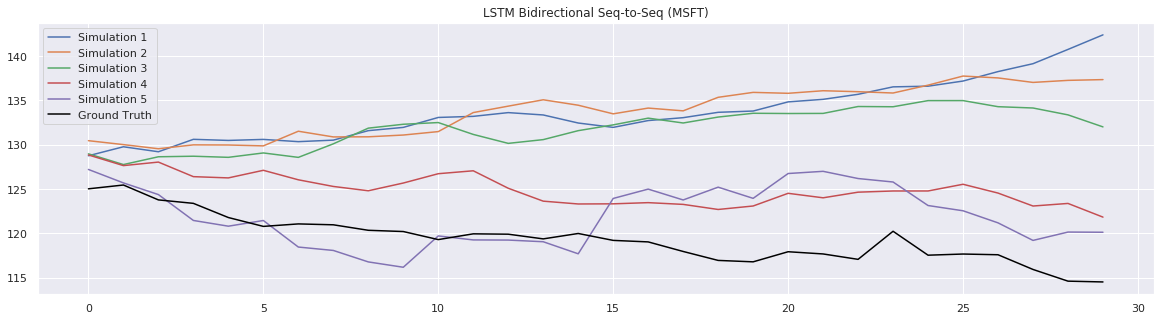

In [91]:
acc11 = [calculate_accuracy(df['4. close'].iloc[-test_size:].values, r) for r in results11]
top_5_idx = np.argsort(acc11)[-5:]
results11 = [results11[i] for i in top_5_idx]
acc11 = [calculate_accuracy(df['4. close'].iloc[-test_size:].values, r) for r in results11]

plt.figure(figsize = (20, 5))
for no, r in enumerate(results11):
    plt.plot(r, label = 'Simulation %d'%(no + 1))
    
plt.plot(df['4. close'].iloc[-test_size:].values, label = 'Ground Truth', c = 'black')
plt.legend()
plt.title('LSTM Bidirectional Seq-to-Seq (MSFT)')
plt.show()

In [92]:
# Variational Auto-Encoder
class LSTM_seq2seq_vae:
    def __init__(
        self,
        learning_rate,
        num_layers,
        size,
        size_layer,
        output_size,
        forget_bias = 0.1,
        lambda_coeff = 0.5
    ):
        def lstm_cell(size_layer):
            return tf.nn.rnn_cell.LSTMCell(size_layer, state_is_tuple = False)

        rnn_cells = tf.nn.rnn_cell.MultiRNNCell(
            [lstm_cell(size_layer) for _ in range(num_layers)],
            state_is_tuple = False,
        )
        self.X = tf.placeholder(tf.float32, (None, None, size))
        self.Y = tf.placeholder(tf.float32, (None, output_size))
        drop = tf.contrib.rnn.DropoutWrapper(
            rnn_cells, output_keep_prob = forget_bias
        )
        self.hidden_layer = tf.placeholder(
            tf.float32, (None, num_layers * 2 * size_layer)
        )
        _, last_state = tf.nn.dynamic_rnn(
            drop, self.X, initial_state = self.hidden_layer, dtype = tf.float32
        )
        
        self.z_mean = tf.layers.dense(last_state, size)
        self.z_log_sigma = tf.layers.dense(last_state, size)
        
        epsilon = tf.random_normal(tf.shape(self.z_log_sigma))
        self.z_vector = self.z_mean + tf.exp(self.z_log_sigma)
        
        with tf.variable_scope('decoder', reuse = False):
            rnn_cells_dec = tf.nn.rnn_cell.MultiRNNCell(
                [lstm_cell(size_layer) for _ in range(num_layers)], state_is_tuple = False
            )
            drop_dec = tf.contrib.rnn.DropoutWrapper(
                rnn_cells_dec, output_keep_prob = forget_bias
            )
            x = tf.concat([tf.expand_dims(self.z_vector, axis=0), self.X], axis = 1)
            self.outputs, self.last_state = tf.nn.dynamic_rnn(
                drop_dec, self.X, initial_state = last_state, dtype = tf.float32
            )
            
        self.logits = tf.layers.dense(self.outputs[-1], output_size)
        self.lambda_coeff = lambda_coeff
        
        self.kl_loss = -0.5 * tf.reduce_sum(1.0 + 2 * self.z_log_sigma - self.z_mean ** 2 - 
                             tf.exp(2 * self.z_log_sigma), 1)
        self.kl_loss = tf.scalar_mul(self.lambda_coeff, self.kl_loss)
        self.cost = tf.compat.v1.losses.mean_squared_error(self.Y, self.logits)
        self.optimizer = tf.train.AdamOptimizer(learning_rate).minimize(
            self.cost
        )

In [93]:
results12 = []
for i in range(simulation_size):
    print('simulation %d'%(i + 1))
    tf.reset_default_graph()
    modelnn = LSTM_seq2seq_vae(
        learning_rate, num_layers, df_log.shape[1], size_layer, df_log.shape[1], dropout_rate
    )
    sess = tf.InteractiveSession()
    sess.run(tf.global_variables_initializer())
    now = datetime.datetime.now()
    
    ## Training
    for i in range(epoch):
        init_value = np.zeros((1, num_layers * 2 * size_layer))
        total_loss, total_acc = [], []
        for k in range(0, df_train.shape[0] - 1, timestamp):
            index = min(k + timestamp, df_train.shape[0] - 1)
            batch_x = np.expand_dims(
                df_train.iloc[k : index, :].values, axis = 0
            )
            batch_x = np.random.binomial(1, 0.5, batch_x.shape) * batch_x
            batch_y = df_train.iloc[k + 1 : index + 1, :].values
            logits, last_state, _, loss = sess.run(
                [modelnn.logits, modelnn.last_state, modelnn.optimizer, modelnn.cost],
                feed_dict = {
                    modelnn.X: batch_x,
                    modelnn.Y: batch_y,
                    modelnn.hidden_layer: init_value,
                },
            )        
            init_value = last_state
            total_loss.append(loss)
            total_acc.append(calculate_accuracy(batch_y[:, 0], logits[:, 0]))
           
    fin = datetime.datetime.now()
    print(fin-now)
    ## Testing
    future_day = test_size

    output_predict = np.zeros((df_train.shape[0] + future_day, df_train.shape[1]))
    output_predict[0] = df_train.iloc[0]
    upper_b = (df_train.shape[0] // timestamp) * timestamp
    init_value = np.zeros((1, num_layers * 2 * size_layer))

    for k in range(0, (df_train.shape[0] // timestamp) * timestamp, timestamp):
        out_logits, last_state = sess.run(
            [modelnn.logits, modelnn.last_state],
            feed_dict = {
                modelnn.X: np.expand_dims(
                    df_train.iloc[k : k + timestamp], axis = 0
                ),
                modelnn.hidden_layer: init_value,
            },
        )
        init_value = last_state
        output_predict[k + 1 : k + timestamp + 1] = out_logits

    if upper_b != df_train.shape[0]:
        out_logits, last_state = sess.run(
            [modelnn.logits, modelnn.last_state],
            feed_dict = {
                modelnn.X: np.expand_dims(df_train.iloc[upper_b:], axis = 0),
                modelnn.hidden_layer: init_value,
            },
        )
        output_predict[upper_b + 1 : df_train.shape[0] + 1] = out_logits
        future_day -= 1
        
    init_value = last_state
    
    for i in range(future_day):
        o = output_predict[-future_day - timestamp + i:-future_day + i]
        out_logits, last_state = sess.run(
            [modelnn.logits, modelnn.last_state],
            feed_dict = {
                modelnn.X: np.expand_dims(o, axis = 0),
                modelnn.hidden_layer: init_value,
            },
        )
        init_value = last_state
        output_predict[-future_day + i] = out_logits[-1]
    
    output_predict = minmax.inverse_transform(output_predict)
    deep_future = anchor(output_predict[:, 0], 0.3)
    
    results12.append(deep_future[-test_size:])

W0315 03:55:48.407356 140339716040512 rnn_cell_impl.py:893] <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x7f9684768ba8>: Using a concatenated state is slower and will soon be deprecated.  Use state_is_tuple=True.
W0315 03:55:48.536203 140339716040512 rnn_cell_impl.py:893] <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x7f96846db940>: Using a concatenated state is slower and will soon be deprecated.  Use state_is_tuple=True.


simulation 1
0:05:28.396221


W0315 04:01:18.607129 140339716040512 rnn_cell_impl.py:893] <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x7f96843755f8>: Using a concatenated state is slower and will soon be deprecated.  Use state_is_tuple=True.
W0315 04:01:18.757510 140339716040512 rnn_cell_impl.py:893] <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x7f9670a02978>: Using a concatenated state is slower and will soon be deprecated.  Use state_is_tuple=True.


simulation 2
0:05:29.498320


W0315 04:06:49.993055 140339716040512 rnn_cell_impl.py:893] <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x7f96706e2898>: Using a concatenated state is slower and will soon be deprecated.  Use state_is_tuple=True.
W0315 04:06:50.139411 140339716040512 rnn_cell_impl.py:893] <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x7f965bdf7ef0>: Using a concatenated state is slower and will soon be deprecated.  Use state_is_tuple=True.


simulation 3
0:05:24.950311


W0315 04:12:16.784950 140339716040512 rnn_cell_impl.py:893] <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x7f965a153860>: Using a concatenated state is slower and will soon be deprecated.  Use state_is_tuple=True.
W0315 04:12:16.937567 140339716040512 rnn_cell_impl.py:893] <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x7f96598fcf28>: Using a concatenated state is slower and will soon be deprecated.  Use state_is_tuple=True.


simulation 4
0:05:42.142290


W0315 04:18:00.830995 140339716040512 rnn_cell_impl.py:893] <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x7f963fd3e9b0>: Using a concatenated state is slower and will soon be deprecated.  Use state_is_tuple=True.
W0315 04:18:00.983842 140339716040512 rnn_cell_impl.py:893] <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x7f963f48b080>: Using a concatenated state is slower and will soon be deprecated.  Use state_is_tuple=True.


simulation 5
0:05:19.825504


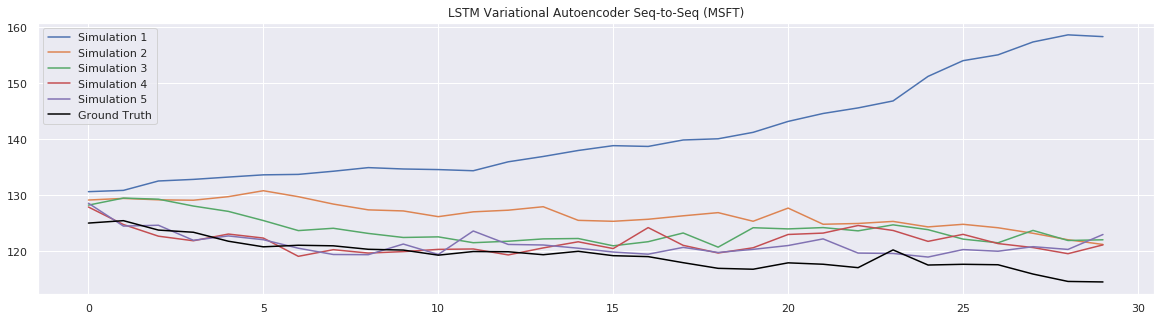

In [94]:
acc12 = [calculate_accuracy(df['4. close'].iloc[-test_size:].values, r) for r in results12]
top_5_idx = np.argsort(acc12)[-5:]
results12 = [results12[i] for i in top_5_idx]
acc12 = [calculate_accuracy(df['4. close'].iloc[-test_size:].values, r) for r in results12]

plt.figure(figsize = (20, 5))
for no, r in enumerate(results12):
    plt.plot(r, label = 'Simulation %d'%(no + 1))
    
plt.plot(df['4. close'].iloc[-test_size:].values, label = 'Ground Truth', c = 'black')
plt.legend()
plt.title('LSTM Variational Autoencoder Seq-to-Seq (MSFT)')
plt.show()

In [95]:
class GRU_seq2seq:
    def __init__(
        self,
        learning_rate,
        num_layers,
        size,
        size_layer,
        output_size,
        forget_bias = 0.1,
    ):
        def lstm_cell(size_layer):
            return tf.nn.rnn_cell.GRUCell(size_layer)

        rnn_cells = tf.nn.rnn_cell.MultiRNNCell(
            [lstm_cell(size_layer) for _ in range(num_layers)],
            state_is_tuple = False,
        )
        self.X = tf.placeholder(tf.float32, (None, None, size))
        self.Y = tf.placeholder(tf.float32, (None, output_size))
        drop = tf.contrib.rnn.DropoutWrapper(
            rnn_cells, output_keep_prob = forget_bias
        )
        self.hidden_layer = tf.placeholder(
            tf.float32, (None, num_layers * size_layer)
        )
        _, last_state = tf.nn.dynamic_rnn(
            drop, self.X, initial_state = self.hidden_layer, dtype = tf.float32
        )
        
        with tf.variable_scope('decoder', reuse = False):
            rnn_cells_dec = tf.nn.rnn_cell.MultiRNNCell(
                [lstm_cell(size_layer) for _ in range(num_layers)], state_is_tuple = False
            )
            drop_dec = tf.contrib.rnn.DropoutWrapper(
                rnn_cells_dec, output_keep_prob = forget_bias
            )
            self.outputs, self.last_state = tf.nn.dynamic_rnn(
                drop_dec, self.X, initial_state = last_state, dtype = tf.float32
            )
            
        self.logits = tf.layers.dense(self.outputs[-1], output_size)
        self.cost = tf.compat.v1.losses.mean_squared_error(self.Y, self.logits)
        self.optimizer = tf.train.AdamOptimizer(learning_rate).minimize(
            self.cost
        )

In [110]:
results13 = []
for i in range(simulation_size):
    print('simulation %d'%(i + 1))
    tf.reset_default_graph()
    modelnn = GRU_seq2seq(
        learning_rate, num_layers, df_log.shape[1], size_layer, df_log.shape[1], dropout_rate
    )
    sess = tf.InteractiveSession()
    sess.run(tf.global_variables_initializer())
    now = datetime.datetime.now()
    
    ## Training
    for i in range(epoch):
        init_value = np.zeros((1, num_layers * size_layer))
        total_loss, total_acc = [], []
        for k in range(0, df_train.shape[0] - 1, timestamp):
            index = min(k + timestamp, df_train.shape[0] - 1)
            batch_x = np.expand_dims(
                df_train.iloc[k : index, :].values, axis = 0
            )
            batch_y = df_train.iloc[k + 1 : index + 1, :].values
            logits, last_state, _, loss = sess.run(
                [modelnn.logits, modelnn.last_state, modelnn.optimizer, modelnn.cost],
                feed_dict = {
                    modelnn.X: batch_x,
                    modelnn.Y: batch_y,
                    modelnn.hidden_layer: init_value,
                },
            )        
            init_value = last_state
            total_loss.append(loss)
            total_acc.append(calculate_accuracy(batch_y[:, 0], logits[:, 0]))
            
    fin = datetime.datetime.now()
    print(fin-now)
    
    ## Testing
    future_day = test_size

    output_predict = np.zeros((df_train.shape[0] + future_day, df_train.shape[1]))
    output_predict[0] = df_train.iloc[0]
    upper_b = (df_train.shape[0] // timestamp) * timestamp
    init_value = np.zeros((1, num_layers * size_layer))

    for k in range(0, (df_train.shape[0] // timestamp) * timestamp, timestamp):
        out_logits, last_state = sess.run(
            [modelnn.logits, modelnn.last_state],
            feed_dict = {
                modelnn.X: np.expand_dims(
                    df_train.iloc[k : k + timestamp], axis = 0
                ),
                modelnn.hidden_layer: init_value,
            },
        )
        init_value = last_state
        output_predict[k + 1 : k + timestamp + 1] = out_logits

    if upper_b != df_train.shape[0]:
        out_logits, last_state = sess.run(
            [modelnn.logits, modelnn.last_state],
            feed_dict = {
                modelnn.X: np.expand_dims(df_train.iloc[upper_b:], axis = 0),
                modelnn.hidden_layer: init_value,
            },
        )
        output_predict[upper_b + 1 : df_train.shape[0] + 1] = out_logits
        future_day -= 1
        
    init_value = last_state
    
    for i in range(future_day):
        o = output_predict[-future_day - timestamp + i:-future_day + i]
        out_logits, last_state = sess.run(
            [modelnn.logits, modelnn.last_state],
            feed_dict = {
                modelnn.X: np.expand_dims(o, axis = 0),
                modelnn.hidden_layer: init_value,
            },
        )
        init_value = last_state
        output_predict[-future_day + i] = out_logits[-1]
        
    output_predict = minmax.inverse_transform(output_predict)
    deep_future = anchor(output_predict[:, 0], 0.3)
    
    results13.append(deep_future[-test_size:])

simulation 1
0:04:41.609237


In [111]:
#results13 = np.delete(results13, 0, 0)
z = list(results13)
z.append(np.array(deep_future[-test_size:]))
results13 = z

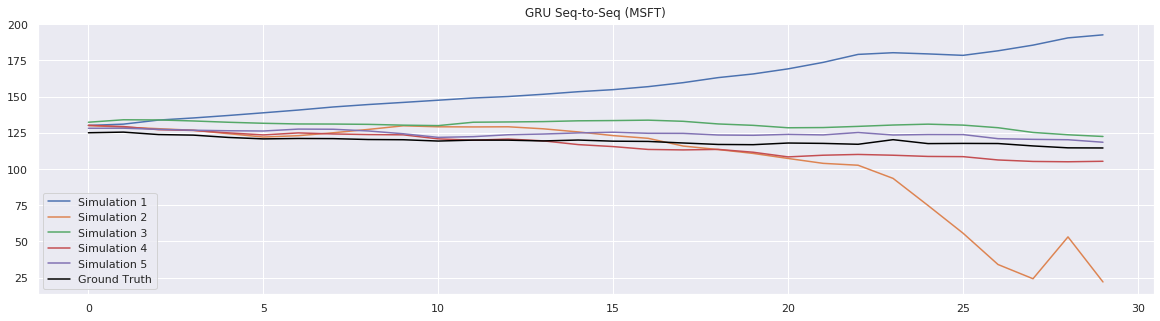

[62.79758867224315,
 70.74559744582871,
 90.46095548196563,
 94.78365865505981,
 95.68353944099475]

In [112]:
acc13 = [calculate_accuracy(df['4. close'].iloc[-test_size:].values, r) for r in results13]
top_5_idx = np.argsort(acc13)[-5:]
results13 = [results13[i] for i in top_5_idx]
acc13 = [calculate_accuracy(df['4. close'].iloc[-test_size:].values, r) for r in results13]

plt.figure(figsize = (20, 5))
for no, r in enumerate(results13):
    plt.plot(r, label = 'Simulation %d'%(no + 1))
    
plt.plot(df['4. close'].iloc[-test_size:].values, label = 'Ground Truth', c = 'black')
plt.legend()
plt.title('GRU Seq-to-Seq (MSFT)')
plt.show()
acc13

In [98]:
class GRU_seq2seq_bid:
    def __init__(
        self,
        learning_rate,
        num_layers,
        size,
        size_layer,
        output_size,
        forget_bias = 0.1,
    ):
        def lstm_cell(size_layer):
            return tf.nn.rnn_cell.GRUCell(size_layer)

        backward_rnn_cells = tf.nn.rnn_cell.MultiRNNCell(
            [lstm_cell(size_layer) for _ in range(num_layers)],
            state_is_tuple = False,
        )
        forward_rnn_cells = tf.nn.rnn_cell.MultiRNNCell(
            [lstm_cell(size_layer) for _ in range(num_layers)],
            state_is_tuple = False,
        )
        self.X = tf.placeholder(tf.float32, (None, None, size))
        self.Y = tf.placeholder(tf.float32, (None, output_size))
        drop_backward = tf.contrib.rnn.DropoutWrapper(
            backward_rnn_cells, output_keep_prob = forget_bias
        )
        forward_backward = tf.contrib.rnn.DropoutWrapper(
            forward_rnn_cells, output_keep_prob = forget_bias
        )
        self.backward_hidden_layer = tf.placeholder(
            tf.float32, shape = (None, num_layers * size_layer)
        )
        self.forward_hidden_layer = tf.placeholder(
            tf.float32, shape = (None, num_layers * size_layer)
        )
        _, last_state = tf.nn.bidirectional_dynamic_rnn(
            forward_backward,
            drop_backward,
            self.X,
            initial_state_fw = self.forward_hidden_layer,
            initial_state_bw = self.backward_hidden_layer,
            dtype = tf.float32,
        )
        
        with tf.variable_scope('decoder', reuse = False):
            backward_rnn_cells_decoder = tf.nn.rnn_cell.MultiRNNCell(
            [lstm_cell(size_layer) for _ in range(num_layers)],
            state_is_tuple = False,
            )
            forward_rnn_cells_decoder = tf.nn.rnn_cell.MultiRNNCell(
                [lstm_cell(size_layer) for _ in range(num_layers)],
                state_is_tuple = False,
            )
            drop_backward_decoder = tf.contrib.rnn.DropoutWrapper(
            backward_rnn_cells_decoder, output_keep_prob = forget_bias
            )
            forward_backward_decoder = tf.contrib.rnn.DropoutWrapper(
                forward_rnn_cells_decoder, output_keep_prob = forget_bias
            )
            self.outputs, self.last_state = tf.nn.bidirectional_dynamic_rnn(
                forward_backward_decoder, drop_backward_decoder, self.X, 
                initial_state_fw = last_state[0],
                initial_state_bw = last_state[1],
                dtype = tf.float32
            )
        self.outputs = tf.concat(self.outputs, 2)
        self.logits = tf.layers.dense(self.outputs[-1], output_size)
        self.cost = tf.compat.v1.losses.mean_squared_error(self.Y, self.logits)
        self.optimizer = tf.train.AdamOptimizer(learning_rate).minimize(
            self.cost
        )

In [99]:
results14 = []
for i in range(simulation_size):
    print('simulation %d'%(i + 1))
    tf.reset_default_graph()
    modelnn = GRU_seq2seq_bid(
        learning_rate, num_layers, df_log.shape[1], size_layer, df_log.shape[1], dropout_rate
    )
    sess = tf.InteractiveSession()
    sess.run(tf.global_variables_initializer())
    now = datetime.datetime.now()
    
    ## Training
    for i in range(epoch):
        init_value_forward = np.zeros((1, num_layers * size_layer))
        init_value_backward = np.zeros((1, num_layers * size_layer))
        total_loss, total_acc = [], []
        for k in range(0, df_train.shape[0] - 1, timestamp):
            index = min(k + timestamp, df_train.shape[0] - 1)
            batch_x = np.expand_dims(
                df_train.iloc[k : index, :].values, axis = 0
            )
            batch_y = df_train.iloc[k + 1 : index + 1, :].values
            logits, last_state, _, loss = sess.run(
                [modelnn.logits, modelnn.last_state, modelnn.optimizer, modelnn.cost],
                feed_dict = {
                    modelnn.X: batch_x,
                    modelnn.Y: batch_y,
                    modelnn.backward_hidden_layer: init_value_backward,
                    modelnn.forward_hidden_layer: init_value_forward,
                },
            )        
            init_value_forward = last_state[0]
            init_value_backward = last_state[1]
            total_loss.append(loss)
            total_acc.append(calculate_accuracy(batch_y[:, 0], logits[:, 0]))
            
    fin = datetime.datetime.now()
    print(fin-now)
    
    ## Testing
    future_day = test_size

    output_predict = np.zeros((df_train.shape[0] + future_day, df_train.shape[1]))
    output_predict[0] = df_train.iloc[0]
    upper_b = (df_train.shape[0] // timestamp) * timestamp
    init_value_forward = np.zeros((1, num_layers * size_layer))
    init_value_backward = np.zeros((1, num_layers * size_layer))

    for k in range(0, (df_train.shape[0] // timestamp) * timestamp, timestamp):
        out_logits, last_state = sess.run(
            [modelnn.logits, modelnn.last_state],
            feed_dict = {
                modelnn.X: np.expand_dims(
                    df_train.iloc[k : k + timestamp], axis = 0
                ),
                modelnn.backward_hidden_layer: init_value_backward,
                modelnn.forward_hidden_layer: init_value_forward,
            },
        )
        init_value_forward = last_state[0]
        init_value_backward = last_state[1]
        output_predict[k + 1 : k + timestamp + 1] = out_logits

    if upper_b != df_train.shape[0]:
        out_logits, last_state = sess.run(
            [modelnn.logits, modelnn.last_state],
            feed_dict = {
                modelnn.X: np.expand_dims(df_train.iloc[upper_b:], axis = 0),
                modelnn.backward_hidden_layer: init_value_backward,
                modelnn.forward_hidden_layer: init_value_forward,
            },
        )
        output_predict[upper_b + 1 : df_train.shape[0] + 1] = out_logits
        future_day -= 1
        
    init_value_forward = last_state[0]
    init_value_backward = last_state[1]
    
    for i in range(future_day):
        o = output_predict[-future_day - timestamp + i:-future_day + i]
        out_logits, last_state = sess.run(
            [modelnn.logits, modelnn.last_state],
            feed_dict = {
                modelnn.X: np.expand_dims(o, axis = 0),
                modelnn.backward_hidden_layer: init_value_backward,
                modelnn.forward_hidden_layer: init_value_forward,
            },
        )
        init_value_forward = last_state[0]
        init_value_backward = last_state[1]
        output_predict[-future_day + i] = out_logits[-1]
        
    output_predict = minmax.inverse_transform(output_predict)
    deep_future = anchor(output_predict[:, 0], 0.3)
    
    results14.append(deep_future[-test_size:])

simulation 1
0:07:14.085407
simulation 2
0:07:18.439027
simulation 3
0:07:14.920892
simulation 4
0:07:13.091634
simulation 5
0:07:12.850593


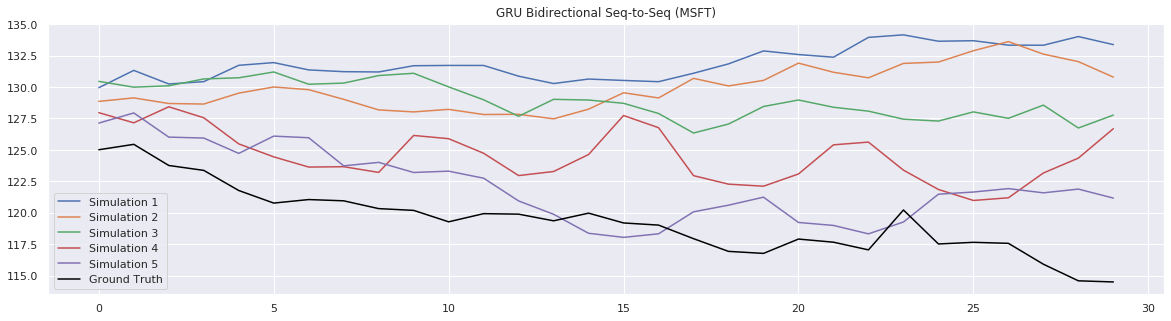

In [100]:
acc14 = [calculate_accuracy(df['4. close'].iloc[-test_size:].values, r) for r in results14]
top_5_idx = np.argsort(acc14)[-5:]
results14 = [results14[i] for i in top_5_idx]
acc14 = [calculate_accuracy(df['4. close'].iloc[-test_size:].values, r) for r in results14]

plt.figure(figsize = (20, 5))
for no, r in enumerate(results14):
    plt.plot(r, label = 'Simulation %d'%(no + 1))
    
plt.plot(df['4. close'].iloc[-test_size:].values, label = 'Ground Truth', c = 'black')
plt.legend()
plt.title('GRU Bidirectional Seq-to-Seq (MSFT)')
plt.show()

In [101]:
class GRU_seq2seq_vae:
    def __init__(
        self,
        learning_rate,
        num_layers,
        size,
        size_layer,
        output_size,
        forget_bias = 0.1,
        lambda_coeff = 0.5
    ):
        def lstm_cell(size_layer):
            return tf.nn.rnn_cell.GRUCell(size_layer)

        rnn_cells = tf.nn.rnn_cell.MultiRNNCell(
            [lstm_cell(size_layer) for _ in range(num_layers)],
            state_is_tuple = False,
        )
        self.X = tf.placeholder(tf.float32, (None, None, size))
        self.Y = tf.placeholder(tf.float32, (None, output_size))
        drop = tf.contrib.rnn.DropoutWrapper(
            rnn_cells, output_keep_prob = forget_bias
        )
        self.hidden_layer = tf.placeholder(
            tf.float32, (None, num_layers * size_layer)
        )
        _, last_state = tf.nn.dynamic_rnn(
            drop, self.X, initial_state = self.hidden_layer, dtype = tf.float32
        )
        
        self.z_mean = tf.layers.dense(last_state, size)
        self.z_log_sigma = tf.layers.dense(last_state, size)
        
        epsilon = tf.random_normal(tf.shape(self.z_log_sigma))
        self.z_vector = self.z_mean + tf.exp(self.z_log_sigma)
        
        with tf.variable_scope('decoder', reuse = False):
            rnn_cells_dec = tf.nn.rnn_cell.MultiRNNCell(
                [lstm_cell(size_layer) for _ in range(num_layers)], state_is_tuple = False
            )
            drop_dec = tf.contrib.rnn.DropoutWrapper(
                rnn_cells_dec, output_keep_prob = forget_bias
            )
            x = tf.concat([tf.expand_dims(self.z_vector, axis=0), self.X], axis = 1)
            self.outputs, self.last_state = tf.nn.dynamic_rnn(
                drop_dec, self.X, initial_state = last_state, dtype = tf.float32
            )
            
        self.logits = tf.layers.dense(self.outputs[-1], output_size)
        self.lambda_coeff = lambda_coeff
        
        self.kl_loss = -0.5 * tf.reduce_sum(1.0 + 2 * self.z_log_sigma - self.z_mean ** 2 - 
                             tf.exp(2 * self.z_log_sigma), 1)
        self.kl_loss = tf.scalar_mul(self.lambda_coeff, self.kl_loss)
        self.cost = tf.compat.v1.losses.mean_squared_error(self.Y, self.logits)
        self.optimizer = tf.train.AdamOptimizer(learning_rate).minimize(
            self.cost
        )

In [102]:
results15 = []
for i in range(simulation_size):
    print('simulation %d'%(i + 1))
    tf.reset_default_graph()
    modelnn = GRU_seq2seq_vae(
        learning_rate, num_layers, df_log.shape[1], size_layer, df_log.shape[1], dropout_rate
    )
    sess = tf.InteractiveSession()
    sess.run(tf.global_variables_initializer())
    now = datetime.datetime.now()
    
    ## Training
    for i in range(epoch):
        init_value = np.zeros((1, num_layers * size_layer))
        total_loss, total_acc = [], []
        for k in range(0, df_train.shape[0] - 1, timestamp):
            index = min(k + timestamp, df_train.shape[0] - 1)
            batch_x = np.expand_dims(
                df_train.iloc[k : index, :].values, axis = 0
            )
            batch_x = np.random.binomial(1, 0.5, batch_x.shape) * batch_x
            batch_y = df_train.iloc[k + 1 : index + 1, :].values
            logits, last_state, _, loss = sess.run(
                [modelnn.logits, modelnn.last_state, modelnn.optimizer, modelnn.cost],
                feed_dict = {
                    modelnn.X: batch_x,
                    modelnn.Y: batch_y,
                    modelnn.hidden_layer: init_value,
                },
            )        
            init_value = last_state
            total_loss.append(loss)
            total_acc.append(calculate_accuracy(batch_y[:, 0], logits[:, 0]))
            
    fin = datetime.datetime.now()
    print(fin-now)
    
    ## Testing
    future_day = test_size
    
    output_predict = np.zeros((df_train.shape[0] + future_day, df_train.shape[1]))
    output_predict[0] = df_train.iloc[0]
    upper_b = (df_train.shape[0] // timestamp) * timestamp
    init_value = np.zeros((1, num_layers * size_layer))

    for k in range(0, (df_train.shape[0] // timestamp) * timestamp, timestamp):
        out_logits, last_state = sess.run(
            [modelnn.logits, modelnn.last_state],
            feed_dict = {
                modelnn.X: np.expand_dims(
                    df_train.iloc[k : k + timestamp], axis = 0
                ),
                modelnn.hidden_layer: init_value,
            },
        )
        init_value = last_state
        output_predict[k + 1 : k + timestamp + 1] = out_logits

    if upper_b != df_train.shape[0]:
        out_logits, last_state = sess.run(
            [modelnn.logits, modelnn.last_state],
            feed_dict = {
                modelnn.X: np.expand_dims(df_train.iloc[upper_b:], axis = 0),
                modelnn.hidden_layer: init_value,
            },
        )
        output_predict[upper_b + 1 : df_train.shape[0] + 1] = out_logits
        future_day -= 1
        
    init_value = last_state
    
    for i in range(future_day):
        o = output_predict[-future_day - timestamp + i:-future_day + i]
        out_logits, last_state = sess.run(
            [modelnn.logits, modelnn.last_state],
            feed_dict = {
                modelnn.X: np.expand_dims(o, axis = 0),
                modelnn.hidden_layer: init_value,
            },
        )
        init_value = last_state
        output_predict[-future_day + i] = out_logits[-1]
        
    output_predict = minmax.inverse_transform(output_predict)
    deep_future = anchor(output_predict[:, 0], 0.3)
    
    results15.append(deep_future[-test_size:])

simulation 1
0:04:59.132277
simulation 2
0:04:55.735735
simulation 3
0:04:42.924365
simulation 4
0:04:39.641971
simulation 5
0:04:41.382637


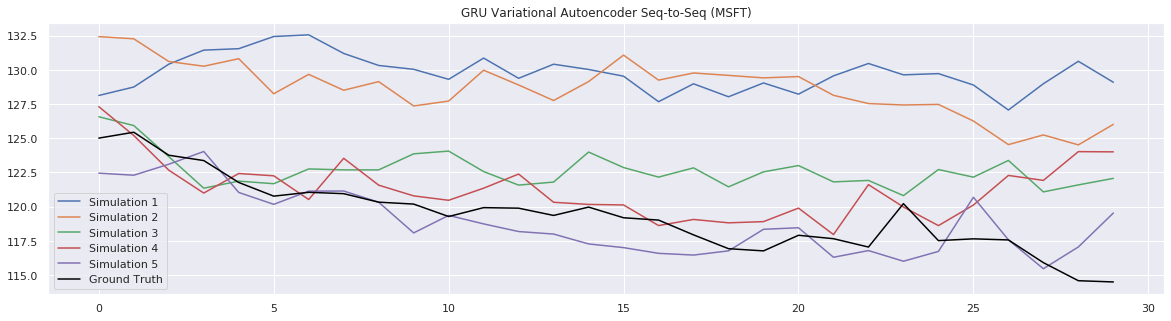

In [103]:
acc15 = [calculate_accuracy(df['4. close'].iloc[-test_size:].values, r) for r in results15]
top_5_idx = np.argsort(acc15)[-5:]
results15 = [results15[i] for i in top_5_idx]
acc15 = [calculate_accuracy(df['4. close'].iloc[-test_size:].values, r) for r in results15]

plt.figure(figsize = (20, 5))
for no, r in enumerate(results15):
    plt.plot(r, label = 'Simulation %d'%(no + 1))
    
plt.plot(df['4. close'].iloc[-test_size:].values, label = 'Ground Truth', c = 'black')
plt.legend()
plt.title('GRU Variational Autoencoder Seq-to-Seq (MSFT)')
plt.show()

In [113]:
# 0.005 LR
print('%.4f'%(np.mean(acc1)))
print('%.4f'%(np.mean(acc2)))
print('%.4f'%(np.mean(acc3)))
print('%.4f'%(np.mean(acc4)))
print('%.4f'%(np.mean(acc5)))
print('%.4f'%(np.mean(acc6)))
print('%.4f'%(np.mean(acc7)))
print('%.4f'%(np.mean(acc8)))
print('%.4f'%(np.mean(acc9)))
print('%.4f'%(np.mean(acc10)))
print('%.4f'%(np.mean(acc11)))
print('%.4f'%(np.mean(acc12)))
print('%.4f'%(np.mean(acc13)))
print('%.4f'%(np.mean(acc14)))
print('%.4f'%(np.mean(acc15)))

94.7839
91.5778
87.0947
82.7840
91.3575
90.1394
81.3482
80.3630
81.3212
83.0279
90.8102
92.8373
82.8943
92.7294
95.0882


In [111]:
print('%.4f'%(np.mean(acc1)))
print('%.4f'%(np.mean(acc2)))
print('%.4f'%(np.mean(acc3)))
print('%.4f'%(np.mean(acc4)))
print('%.4f'%(np.mean(acc5)))
print('%.4f'%(np.mean(acc6)))
print('%.4f'%(np.mean(acc7)))
print('%.4f'%(np.mean(acc8)))
print('%.4f'%(np.mean(acc10)))
print('%.4f'%(np.mean(acc11)))
print('%.4f'%(np.mean(acc12)))
print('%.4f'%(np.mean(acc13)))
print('%.4f'%(np.mean(acc14)))
print('%.4f'%(np.mean(acc15)))

96.7865
97.5174
95.8610
96.7371
95.7013
95.6463
79.9077
81.0493
83.8494
94.8605
93.7858
97.4910
78.6263
64.8216
77.0067


In [114]:
a1 = np.array(results)
a2 = np.array(results2)
a3 = np.array(results3)
a4 = np.array(results4)
a5 = np.array(results5)
a6 = np.array(results6)
a7 = np.array(results7)
a8 = np.array(results8)
a9 = np.array(results9)
a10 = np.array(results10)
a11 = np.array(results11)
a12 = np.array(results12)
a13 = np.array(results13)
a14 = np.array(results14)
a15 = np.array(results15)

In [71]:
np.save('msft_lstm.npy', a1)
np.save('msft_lstm_bid.npy', a2)
np.save('msft_lstm_sum.npy', a3)
np.save('msft_gru.npy', a4)
np.save('msft_gru_bid.npy', a5)
np.save('msft_gru_sum.npy', a6)
np.save('msft_vrnn.npy', a7)
np.save('msft_vrnn_bid.npy', a8)
np.save('msft_vrnn_sum.npy', a9)
np.save('msft_seq2seq.npy', a10)
np.save('msft_seq2seq_vae.npy', a12)
np.save('msft_seq2seq_bid.npy', a11)
np.save('msft_grubid_seq2seq.npy', a14)
np.save('msft_gru_seq2seq.npy', a13)
np.save('msft_gruvae_seq2seq.npy', a15)

In [115]:
np.save('msft_lstm_lr.npy', a1)
np.save('msft_lstm_bid_lr.npy', a2)
np.save('msft_lstm_sum_lr.npy', a3)
np.save('msft_gru_lr.npy', a4)
np.save('msft_gru_bid_lr.npy', a5)
np.save('msft_gru_sum_lr.npy', a6)
np.save('msft_vrnn_lr.npy', a7)
np.save('msft_vrnn_bid_lr.npy', a8)
np.save('msft_vrnn_sum_lr.npy', a9)
np.save('msft_seq2seq_lr.npy', a10)
np.save('msft_seq2seq_vae_lr.npy', a12)
np.save('msft_seq2seq_bid_lr.npy', a11)
np.save('msft_grubid_seq2seq_lr.npy', a14)
np.save('msft_gru_seq2seq_lr.npy', a13)
np.save('msft_gruvae_seq2seq_lr.npy', a15)